# Predicting Off Target Proteins from a molecular set

Prediction of off target proteins using protein networks, docking and pharmacophore alignement.


--------------

## ! Functions and Classes are herd in large nodes to speed up the preparation of the workflow, their explanations are clearly noted in the README.md !

-------------------

### Status:
- 31/10/2020 - Spooky Halloween
- 16/11/2020 - Version without Pocket detection finalized 
- 02/12/2020 - GitHub ready

---------------

## Introduction
  A set of drugs may not always do what is expected from them. For example, a large part of the clinical trials fail due to undesired and  harmful side-effects posing economic and medical risks. Side-effects appear when a compounds given to an organism starts interacting with unwaned target. This may be due to the similarity of interactions that one ligand is able to do with a protein A and a protein B. The affinity between a ligand and a receptor is driven by the volume of the pocket, the strenth of the interactions and the stability of the cavity. Hence, comparing the fixation of a ligand to multiple pocket became mesurable. This may be done by mesuring the affinity of the complexe in function of the implyied interactions.
  
  If this may done with one ligand, it can be be extend to a molecular familly hence giving the ability to screen the affinity of pockets and the similarities between their interactions for a chemical family. Thus, finding two pockets with favorable energie of adhesion and an high similiraty of interactions may be a step to depicted them as possible Off-Target to a chemical familly. 

--------------

## Protocol
  To do so, a docking workflow has been implemented on a Jupyter Notebook. To take in account the fact that Off-Target may take place in a biochemical pathway, if no protein is giving to the workflow, the program starts by gathering a protein network. The computed network then analysed using a betweness centrality analysis to extract the proteins subject to important protein-protein interactions, on which the transfert of informations is centralised. Using  thoses proteins or a set of given ones, a docking protocol is conducted.
  
   The protocol may resid on a blind docking or it may targets pockets. The pocket docking is established by analysing and extracting from each structure the pocket volume using grids and the Surface Accessible to the Solvent. The pocket docking is far more precise than the blind docking but proportionally computationally time consumming. Instead of docking each compound N times considering N the number of proteins, the docking are managed N times P, the number of pockets by protein which can easily go around 15 to 20. The grid for each docking session is automatically computed and the docking is launched using Vina.
   
   Once the docking computed, the affinity are recovered in function of their protein and pocket. The affinity of each poses per pocket are then compared one-to-one and the difference is computed using a Student test to recover the p-value. On an other side, the poses of each pocket are converted to pharmacophore, treated and then aligned one-to-one to each other pocket and their similarity is computed. 
   
   The graphical representation of the pocket-pocket p-value against the pocket-pocket pharmacophore similarity is used to depicted Off-Target. If two pockets of different protein present high affinity and similarity, it may be possible than the test chemical familly induce Off-Target reactions.

## Modules importation & Data Input

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Modules
import pubchempy as pcp
import mygene
import logging
import requests
import time
import random
import itertools
import pandas as pd
from heapq import heappush, heappop
from itertools import count
import warnings
import operator
from biothings_client import get_client
import pypdb as pyd
import numpy as np
import math
import sys, os
import os.path 
import shutil
from Bio.PDB import *
import ipycytoscape
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import qgrid
import ipywidgets
from ipywidgets import HBox, Label
from rdkit import Chem
import py3Dmol
from rdkit.Chem import Descriptors, rdPartialCharges, GraphDescriptors, rdMolDescriptors, AllChem
import seaborn as sns
import pandas as pd
from ipywidgets import fixed, interact
import copy
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem import PyMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdBase
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdMolDescriptors
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit import Geometry
import networkx as nx; 
from networkx.readwrite import json_graph;
import json
import ipycytoscape
from itertools import combinations
from scipy.stats import ttest_ind
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import plotly.figure_factory as ff
import plotly.express as px

# List of choices
list_activity = ["Active", "Inactive", "Unspecified"]
list_activity_type = ["IC50", "EC50", "AC50", "Kd", "Potency"]
TEST = ["RIKEN FANTOM5",
		"GTEx",
		"Individuals",
		"NIH_Roadmap_Epigenomics_Mapping_Consortium",
		"Illumina_Body_Map",
		"ENCODE",
		"Homo_Tissues",
		"Pandey"]
list_unit = ["TPM", "FPKM"]

# Verify Path
def verify_filedir_exist(input_filedir):
	if input_filedir != "":
		if os.path.isdir(input_filedir) == True:
			return(["The Path to " + input_filedir + " exist", True])
		else:
			return(["The Path to " + input_filedir + " doesn't exist. ! ! ! Please verify the Path ! ! !", False])
        
# Dropdown Widgets    
# Define style to expand the widget's titles
style = {'description_width': 'initial'}

# Activity
activity_show = ipywidgets.Dropdown(
    options=list_activity,
    value=list_activity[0],
    description='Activity',
    style = style)

# Activity type
activity_type_show = ipywidgets.Dropdown(
    options=list_activity_type,
    value=list_activity_type[0],
    description='Activity type',
    style = style)

# Expression Test
gene_show = ipywidgets.Dropdown(
    options=TEST,
    value=TEST[0],
    description='Expression Test',
    style = style)

# Expression Unit
unit_show = ipywidgets.Dropdown(
    options=list_unit,
    value=list_unit[0],
    description='Expression Unit',
    style = style)
        
# Input Molecules Widgets    
molecules_input = ipywidgets.Textarea(
    value= '',
    placeholder='Enter compounds here',
    description='Molecules',
    disabled=False
)

myupload = ipywidgets.FileUpload(
    accept= '.csv', 
    multiple=False,
    description='Upload bank'
)
        
# Input Protein    
# Which area to dock
Network_choice = ipywidgets.RadioButtons(
    value = "Yes: Give path",
    options = ("No : Compute network", "Yes: Give path"),
    description = "User\'s network",
    disabled=False,
    style = style
)

#
Path_to_PDB_folder = ipywidgets.Text(
    value= './Mon_Network//',
    placeholder='./Mon_Network//',
    description='Path to protein\'s Folder',
    disabled=False,
    style = style
)

# Which area to dock
Molecule_choice = ipywidgets.RadioButtons(
    value = "Yes: Give path",
    options = ("No : Compute 3D structure", "Yes: Give path"),
    description = "User\'s compounds",
    disabled=False,
    style = style
)

#
Path_to_Mol_folder = ipywidgets.Text(
    value= './Mes_Molecules//',
    placeholder='./Mes_Molecules//',
    description='Path to molecule\'s Folder',
    disabled=False,
    style = style
)

# 
type_of_level_choice = ipywidgets.RadioButtons(
    value = "Family",
    options = ("Family", "Type"),
    description = "Features category",
    disabled=False,
    style = style
)

# Sliders Widgets
# Activity Cut off
slider_Cut = ipywidgets.IntSlider(
    value=100,
    min=0,
    max=1000,
    step=1,
    description='Activity Cut off',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style
)
slider_Cut.style.handle_color = 'lightgreen'

# Prediction Cut off
slider_STRING_SCORE = ipywidgets.IntSlider(
    value=100,
    min=0,
    max=1000,
    step=1,
    description='Prediction Cut off',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style
)
slider_STRING_SCORE.style.handle_color = 'lightblue'

# Gene exp. Cut off
slider_GEN_EXP = ipywidgets.BoundedFloatText(
    value=0.5,
    min=0.0,
    max=10000.0,
    step=0.1,
    description='Gene exp. Cut off',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style = style
)

# First layer limit
Bound_NUMBER_SCORE = ipywidgets.IntSlider(
    value=6,
    min=0,
    max=50,
    step=1,
    description='First layer limit',
    disabled=False,
    style = style
)
Bound_NUMBER_SCORE.style.handle_color = 'orange'

# Second layer limit
Bound_NUMBER_NODE_ADDITIONAL = ipywidgets.IntSlider(
    value=2,
    min=0,
    max=50,
    step=1,
    description='Second layer limit',
    disabled=False,
    style = style
)
Bound_NUMBER_NODE_ADDITIONAL.style.handle_color = 'yellow'

# Exhaustiveness
Exhaustiveness = ipywidgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='Exhaustiveness',
    disabled=False,
    style = style
)
Exhaustiveness.style.handle_color = 'pink'

# Choose Docking Method
# Which area to dock
Docking_methods = ipywidgets.RadioButtons(
    options = ("Blind-based", "Pocket-based"),
    description = "Docking protocol",
    disabled=False,
    style = style
)

# Verify the Path

def verify_for_Path(Path_widget):
	if Path_widget.value != {}:
		verification_path = verify_filedir_exist(Path_widget.value)
		if verification_path != None:
			print("\n", verification_path[0])
			if verification_path[1] == True:
				compteur_total = 0
				compteur_pdb = 0
				print("---\n", "List of the selected PDBs :", "\n")
				liste_subjets = []
				for file in os.listdir(Path_widget.value):
					if file[-3:] == "pdb":
						print(file[0:-4], "\n")
						liste_subjets.append(file[0:-4])
						compteur_pdb += 1
					compteur_total += 1
				if compteur_pdb != compteur_total:
					print("A fraction of the given files are not PDBs, you may be carefull when executing the code")
				else:
					print("---\n Exerything seems fine")
	return(verification_path[1], liste_subjets)

# Organize the given ligands
# Tranform a dataset of molecules into a list.
def define_bank(content_file):
	uploaded_filename = next(iter(content_file.value))
	content = myupload.value[uploaded_filename]['content']
	Name_list = str(content)[2:-1].split("\\r\\n")
	return(Name_list)

# Choose to transform the molecules's file instead of the molecules given in the 
# text area if a file is given.
def create_Name_list(molecules_input, define_bank, myupload, Molecule_is_verified):
	if molecules_input.value != '':
		if myupload.value != {}:
			Name_list = define_bank(myupload)
		else:
			Name_list = molecules_input.value.split()
	else:
		if myupload.value != {}:
			Name_list = define_bank(myupload)
		else:
			if Molecule_is_verified == True:
				Name_list = Liste_compounds_User
			else:
				Name_list = "! ! ! No Molecules ! ! !"
				print("\n",Name_list, " : Give molecules as input")
	return(Name_list)

# Compounds presentation
def from_name_to_SMILE(mol_name):
	compound_data = pcp.get_compounds(mol_name, 'name')
	Isomeric_SMILE = compound_data[0].isomeric_smiles
	return(Isomeric_SMILE)

def show_molecules_used(Name_list):
    for molecule in Name_list:
        print(molecule)
        display(Chem.MolFromSmiles(str(from_name_to_SMILE(molecule))))
        
def show_molecules_used_3D(Name_list):
    Tot_num = len(Name_list)
    col_widht = int(Tot_num**0.5) + (Tot_num % (Tot_num**0.5) > 0)
    p = py3Dmol.view(viewergrid=(col_widht,col_widht), width=800, height=800)
    p.removeAllModels()
    for i in range(Tot_num):
        m = Chem.AddHs(Chem.MolFromSmiles(str(from_name_to_SMILE(Name_list[i]))))
        _ = AllChem.EmbedMultipleConfs(m, useExpTorsionAnglePrefs=True, useBasicKnowledge=True)
        mb = Chem.MolToMolBlock(m)
        print(Name_list[i])
        p.addModel(mb, viewer=(i//col_widht, i%col_widht))
    p.setStyle({'stick':{}})
    p.zoomTo()
    p.render()
    return(p)

# Saving parameters
def define_parameters(Name_list, activity_type_show, activity_show, slider_Cut, slider_STRING_SCORE, Bound_NUMBER_SCORE,
                 Bound_NUMBER_NODE_ADDITIONAL, gene_show, unit_show, slider_GEN_EXP, Exhaustiveness, Docking_methods,
                 Network_choice, Path_to_PDB_folder, Molecule_choice, Path_to_Mol_folder):
    user_paramaters = {}
    user_paramaters["Name_list"] = Name_list
    user_paramaters["ACTIVITY_TYPE"] = activity_type_show.value
    user_paramaters["ACTIVITY"] = activity_show.value
    user_paramaters["CUT_OFF"] = slider_Cut.value
    user_paramaters["STRING_SCORE"] = slider_STRING_SCORE.value
    user_paramaters["NUMBER_SCORE"] = Bound_NUMBER_SCORE.value
    user_paramaters["NUMBER_NODE_ADDITIONAL"] = Bound_NUMBER_NODE_ADDITIONAL.value
    user_paramaters["CHOIX_TEST"] = gene_show.value
    user_paramaters["UNIT"] = unit_show.value
    user_paramaters["CUT_OFF_GENEXP"] = slider_GEN_EXP.value
    user_paramaters["Exhaustiveness_docking"] = Exhaustiveness.value
    user_paramaters["Docking_protocol"] = Docking_methods.value
    user_paramaters["Network_choice"] = Network_choice.value
    user_paramaters["Path_to_PDB_folder"] = Path_to_PDB_folder.value
    user_paramaters["Molecule_choice"] = Molecule_choice.value
    user_paramaters["Path_to_Mol_folder"] = Path_to_Mol_folder.value
    return(user_paramaters)

# Clean old folders from the main directory
# Tables du reseau donnees ou non
directory_names_Proteins = ["./Proteine", "./Proteine/PDBQT", "./Proteine/PDB"]
directory_names = ["./ProtLig_Complex","./every_pdb_files", "./pdb_files" ,"./SHELL", "./logs", "./mol_files", "./Results", "./Results_keep"]
directory_names_Ligands = ["./Ligands", "./Ligands/PDBQT", "./Ligands/SMILE", "./Ligands/PDB"]


def clean_directory(user_paramaters, directory_names_Proteins, directory_names, directory_names_Ligands):
	if user_paramaters["Molecule_choice"] == "Yes: Give path":
		directory_names_Ligands = directory_names_Ligands[0:2]
	if user_paramaters["Network_choice"] == "Yes: Give path":
		directory_names_Proteins = directory_names_Proteins[0:2]  
	if "Proteine" in os.listdir("./"):
		shutil.rmtree("./Proteine")
	if "Ligands" in os.listdir("./"):
		shutil.rmtree("./Ligands")
	if "SHELL" in os.listdir("./"):
		shutil.rmtree("./SHELL")
	if "ProtLig_Complex" in os.listdir("./"):
		shutil.rmtree("./ProtLig_Complex")
	if "every_pdb_files" in os.listdir("./"):
		shutil.rmtree("./every_pdb_files")
	if "pdb_files" in os.listdir("./"):
		shutil.rmtree("./pdb_files")
	if "logs" in os.listdir("./"):
		shutil.rmtree("./logs")
	if "mol_files" in os.listdir("./"):
		shutil.rmtree("./mol_files")
	if "Results" in os.listdir("./"):
		shutil.rmtree("./Results")
	if "Results_keep" in os.listdir("./"):
		shutil.rmtree("./Results_keep")
	for directory in directory_names:
		os.mkdir(directory)
	for directory in directory_names_Proteins:
		os.mkdir(directory)
	for directory in directory_names_Ligands:
		os.mkdir(directory)

-----------------------


## Class First_layer_graph : Create the First experimental layer of the network

In [3]:
class First_layer_graph:
	"""
	Classe permettant de recuperer des proteines connues pour 
	intéragir expérimentalement avec une ou des molecules donnees

	Input: Liste de composes, définit par leur noms (pour le moment, que le nom)

	Output: Table d'interaction présentant le compose chimique, la valeur d activite,
            et la proteine sujette au type d activite choisit
	"""

    
	def __init__(self):
		"""
		Definition of the variables used to compute the chemical-protein network.
        
		Input : Parameters gave by the user
		"""
		# Unite de l activite
		self.ACTIVITY_TYPE = user_paramaters["ACTIVITY_TYPE"]
		# Type de l'activite
		self.ACTIVITY = user_paramaters["ACTIVITY"]
		# Seuil maximale d activite en nM
		self.CUT_OFF = user_paramaters["CUT_OFF"]
            
        
	def define_compounds(self):
		"""
		Assignation of the molecules used for the computation.
        
		Input : Parameters given by the user
		"""
		self.Name_list = user_paramaters["Name_list"]
		return(self.Name_list)

    
	def CID_from_Name(self, Name_list):
		"""
		Recovers the PubChem CID from the compounds name using pubchempy module
        Then create a link to recover the protein experimental 
        essay assign to each compounds
		
        Input : Parameters given by the user
        Output : Link to recover the interacting protein 
        and the list of the compounds in CID format
		"""
		CID_list = []
		self.Compound_list = []
		for compound in Name_list:
			CID_created = pcp.get_cids(compound, "name", "substance", list_return = "flat")
			CID_list += CID_created
			for iteration in range(0, len(CID_created)):
					self.Compound_list.append([compound, CID_created[iteration]])
		CID_list_str = [str(compound) for compound in CID_list]
		CID_string = ",".join(CID_list_str)
		self.link = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/" + CID_string + "/assaysummary/CSV"
		return(self.link, self.Compound_list)


	def Data_format(self, Data_activity):
		"""
        Transform the recovered data into a table
        
        Input: The assay data recovered using the pubchem request in text format
        Output: The assay results arranged in a table
		"""		
		Data_framed = []
		Data_lined = Data_activity.split("\n")[:-1]
		for line in Data_lined:
			Data_framed.append(line.split(","))
		return(Data_framed[1:])


	def Reducing_data(self, Data_framed):
		"""
        Select useful column for the rest of the analysis like, the Activity, Activity type, the value of
        activity, the protein ID and the species
        
        Input: The assay results arranged in a table
        Output: The column filtered table (on requirements)
		"""		
		self.Assay_data = []
		Wanted_index = [5, 6, 8, 9, 10]
		for assay in Data_framed:
			self.Assay_data.append([Element for i, Element in enumerate(assay) if i in Wanted_index])
		return(self.Assay_data)


	def Clean_data(self, Assay_data):
		"""
        Select rows respecting the given parameters
        
        Input: The column filtered table (on requirements)
        Output: The row filtered table (on parameters)
		"""
		ACTIVITY_TYPE_use = '"' + self.ACTIVITY_TYPE + '"'
		ACTIVITY_use = '"' + self.ACTIVITY + '"'
		self.Clean_assay = []
		for assay in Assay_data:
			if assay[1] == ACTIVITY_use:
					if assay[2] != '""' and assay[3] != '""':
							if float(assay[3]) <= self.CUT_OFF:
									if assay[4] == ACTIVITY_TYPE_use:
										self.Clean_assay.append(assay)
		return(self.Clean_assay)


	def Transform_ID(self, Clean_assay,Compound_list):
		"""
        Convert protein name to geneID
        Reduced the table to the compound name, its activity on the protein and the protein's geneID
        
        Input: The row filtered table (on parameters)
        Output: A table with three columns describing the experimental activity of each compound
		"""
		self.Data_Chemical_Prot = []
		for assay in Clean_assay:
			Id_Mol = int(assay[0])
			Act_mol = float(assay[3])
			for molecule in Compound_list:
				if int(molecule[1]) == Id_Mol:
					Mol_name = molecule[0]
			Gene_data = mg.getgenes(assay[2], fields="symbol")[0]["symbol"]
			self.Data_Chemical_Prot.append([Mol_name.upper(), Act_mol, Gene_data.upper()])
		return(self.Data_Chemical_Prot)


	def execute_first_layer(self):
        # Assign the given compound's list to as variable
		Name_list = self.define_compounds()
        # Generate a link to request the assay data
		link, Compound_list = self.CID_from_Name(Name_list)
        # Request the experimental essay data
		Data_link = requests.get(link)
        # Convert the data to a text format
		Data_activity = Data_link.text
        # Convert the text formated data into a table
		Data_framed = self.Data_format(Data_activity)
        # Keep usefull columns for the analysis
		Assay_data = self.Reducing_data(Data_framed)
        # Filer rows on the given parameters
		Clean_assay = self.Clean_data(Assay_data)
        # Convert protein name to geneID and store the data in a new table
		self.Data_Chemical_Prot = self.Transform_ID(Clean_assay, Compound_list)
		return(self.Data_Chemical_Prot, Name_list)

--------------------------------

## Class Second_layer_graph : Create the Second predicted layer of the network

In [4]:
class Second_layer_graph:
	"""
	Classe permettant de recuperer des proteines prédites pour 
	intéragir avec la première couche de proteine

	Input: Output de First_layer_graph definissant la couche d interaction experimentale

	Output: ...
	"""
    
    
	def __init__(self):
		"""
        Attribution of the parameters to variables to compute the predicted layer of the network
        
        Input: Parameters gave by the user
		"""

		# Seuil minimum pour accepter une interaction predite dans le reseau
		self.STRING_SCORE = user_paramaters["STRING_SCORE"]

		# Nombre limite d'interaction pour la premiere couche de proteine
		self.NUMBER_SCORE = user_paramaters["NUMBER_SCORE"]

		# Nombre limite d interaction pour la seconde couche de proteine
		self.NUMBER_NODE_ADDITIONAL = user_paramaters["NUMBER_NODE_ADDITIONAL"]


	def Get_All_Prot(self, Data_Chemical_Prot):
		"""
        Recover the unique name of each protein
        
        Input: Table describing the interactions between chemicals and proteins
        Output: Liste containing the name of each one of the protei
		"""
        
		self.Prot_name = []
		for interaction in Data_Chemical_Prot:
			if interaction[-1].upper() not in self.Prot_name:
				self.Prot_name.append(interaction[-1].upper())
		self.Prot_name = "&".join(self.Prot_name)
		return(self.Prot_name)


	def Get_String_Data(self, Prot_name):
		"""
        Fetch from the STRING databse the predicted interaction between the given proteins 
        and also new proteins, only present in protein protein interactions
		
        Input: Paramters and list of proteins
        Output: Predicted protein network formated in a table
        """
        
		self.New_data_string = []
		link = "http://string-db.org/api/tsv-no-header/network?identifiers=" + Prot_name + "&required_score=" + str(self.STRING_SCORE) + "&species=9606&limit=" + str(self.NUMBER_SCORE) + "&additional_network_nodes=" + str(self.NUMBER_NODE_ADDITIONAL) + "&format=colon"
		Data_link = requests.get(link)
		Data_text = Data_link.text
		Data_cut = Data_text.split("\n")
		for interaction in Data_cut:
			if interaction != '':
				self.New_data_string.append(interaction.split("\t"))
		return(self.New_data_string)


	def String_Clean(self, New_data_string):
		"""
        Select usefull columns from the given network table
        
        Input: Predicted network table from STRING
        Output: Clean table keeping only the protein's name and their interaction score
		"""
        
		self.Data_Prot_Prot_Unclean = []
		self.Data_Prot_Prot = []
		Wanted_index_string = [2, 3, 12]
		for interaction in New_data_string:
			self.Data_Prot_Prot_Unclean.append([Element for i, Element in enumerate(interaction) if i in Wanted_index_string])
		for score_interaction in self.Data_Prot_Prot_Unclean:
			self.Data_Prot_Prot.append([score_interaction[0], float(score_interaction[2]), score_interaction[1]])
		return(self.Data_Prot_Prot)


	def All_Prot_Get(self, Data_Prot_Prot, Data_Chemical_Prot):
		"""
		Recover the name of each protein in the chemical table and in the all protein table
        
        
        Input: Clean interaction table from the STRING network and from the Pubchem Database
        Output: Liste containing the name of each protein in the network
		"""
        
		self.Total_protein = []
		for protein in Data_Prot_Prot:
			if protein[0] not in self.Total_protein:
				self.Total_protein.append(protein[0])
			if protein[2] not in self.Total_protein:
				self.Total_protein.append(protein[2])
		for protein in Data_Chemical_Prot:
			if protein[2] not in self.Total_protein:
				self.Total_protein.append(protein[2])
		return(self.Total_protein)

    
	def execute_second_layer(self):
		# Recover the name of the proteins in the Pubchem data
		Prot_name = self.Get_All_Prot(Data_Chemical_Prot)
        # Make a request to STRING to fech a predicted protein interaciton network
		New_data_string = self.Get_String_Data(Prot_name)
        # Keep only columns decribing the interactants and their score of interaction in the gave table
		Data_Prot_Prot = self.String_Clean(New_data_string)
        # Recover the name of the proteins in the PubChem and the STRING data
		self.Total_protein = self.All_Prot_Get(Data_Prot_Prot, Data_Chemical_Prot)
        # Return the Pubchem and STRING interaction tables and a list with all the protein names
		return(self.Total_protein, Data_Prot_Prot, Data_Chemical_Prot, Name_list)

----------------------------

## Class Complete_graph : Complete the network with the gene expression of each protein

In [5]:
class Complete_graph:
	"""
	Classe permettant de completer le reseau proteique a l aide d un poids
	etant l expression genetique de chaque proteine

	Input: Output de Second_layer_graph definissant le graphe d interaction proteique

	Output: Trois fichier définissant separement les intéractions molecule-proteine,
			proteine-proteine et le taux d'expression ainsi qu el'organe le plus 
			représentatif pour chaque protéines
	"""

    
	def __init__(self):
		"""
		Definition des variables caracterisant le champ de completion par 
		l expression genetique
		"""

		self.ID_TEST = [
					["RIKEN FANTOM5", "E-MTAB-3358"],
					["GTEx", "E-MTAB-5214"],
					["Individuals", "E-MTAB-2836"],
					["NIH_Roadmap_Epigenomics_Mapping_Consortium", "E-MTAB-3871"],
					["Illumina_Body_Map", "E-MTAB-513"],
					["ENCODE", "E-MTAB-4344"],
					["Homo_Tissues", "E-MTAB-3716"],
					["Pandey", "E-PROT-1"]
					]

		# Base de donnees de l expression genetique analysee
		self.CHOIX_TEST = user_paramaters["CHOIX_TEST"]

		# Unite de l expression genetique
		self.UNIT = user_paramaters["UNIT"]

		# Valeur minimale acceptee pour considerer l expression d une proteine au sein d un organe
		self.CUT_OFF_GENEXP = user_paramaters["CUT_OFF_GENEXP"]

		#
		self.DEBUT_SEP = "%5B%7B%22value%22%3A%22"

		#
		self.FIN_SEP = "%22%7D%5D"
		
		#
		self.SEPARATION = "%22%7D%2C%7B%22value%22%3A%22"

        
	def Choice_from_test(self, CHOIX_TEST):
		"""
        Select the ID corresponding to the gene expression test choosed by the user
        
        Input: Choosed test from ID_TEST
        Output: The ID corresponding to the test
		"""
        
		Index = 0
		ID = 0
		for Sequencing in self.ID_TEST:
			if self.CHOIX_TEST in Sequencing:
				ID = Index
			Index += 1
		self.Choosed_TEST = self.ID_TEST[ID][1]
		return(self.Choosed_TEST)


	def Collect_Exp_Data(self,Total_protein, SEPARATION, DEBUT_SEP, FIN_SEP, Choosed_TEST, UNIT, CUT_OFF_GENEXP, MATRIX_SIZE):
		"""
        Concatenate the proteins's name in a string and request their expression corresponding to the given test
        
        Input: Each protein name, user parameters and strings to complete the link
        Output: Text formated gene expression results
		"""
        
		New_list = SEPARATION.join(Total_protein)
		New_list_2 = DEBUT_SEP + New_list + FIN_SEP
		Exp_link = "https://www.ebi.ac.uk/gxa/experiments-content/"+ Choosed_TEST + "/download/RNASEQ_MRNA_BASELINE?geneQuery=" + New_list_2 + "&unit=" + str(self.UNIT) + "&cutoff=" + str(self.CUT_OFF_GENEXP) + "&filterFactors=%7B" + "DEVELOPMENTAL_STAGE" + "%3A%5B" + "adult" + "%5D%7D" + "&heatmapMatrixSize=" + MATRIX_SIZE + "&selectedColumnIds=g1%2Cg2%2Cg22%2Cg3%2Cg4%2Cg5%2Cg6%2Cg7%2Cg8%2Cg9%2Cg56%2Cg10%2Cg11%2Cg12%2Cg13%2Cg14%2Cg15%2Cg16%2Cg17%2Cg18%2Cg19%2Cg20%2Cg21%2Cg23%2Cg24%2Cg25%2Cg26%2Cg27%2Cg28%2Cg75%2Cg29%2Cg30%2Cg65%2Cg31%2Cg32%2Cg34%2Cg35%2Cg36%2Cg37%2Cg38%2Cg39%2Cg41%2Cg42%2Cg70%2Cg43%2Cg44%2Cg46%2Cg62%2Cg47%2Cg48%2Cg49%2Cg50%2Cg51%2Cg52%2Cg53%2Cg54%2Cg55%2Cg57%2Cg58%2Cg59%2Cg60%2Cg61%2Cg63%2Cg64%2Cg76%2Cg66%2Cg67%2Cg68%2Cg69%2Cg79%2Cg71%2Cg73%2Cg74%2Cg77%2Cg78%2Cg80&type=RNASEQ_MRNA_BASELINE"
		Exp_data_link = requests.get(Exp_link)
		self.Exp_data_text = Exp_data_link.text
		return(self.Exp_data_text)


	def Tab_Shaping_Pr(self,Exp_data_text):
		"""
        Convert the text formated data in a table
        
        Input: Text formated gene expression results
        Output: Table formated gene expression results
		"""
        
		self.Cut_Exp = Exp_data_text.split("\n")
		for Exp_Data in self.Cut_Exp:
			self.Tab_Exp = []
			for Identification in self.Cut_Exp:
				if len(Identification) > 0:
					if Identification[0] != "#":
						self.Tab_Exp.append(Identification.split("\t")[1:])
		return(self.Tab_Exp)


	def Expression_Operator(self,Tab_Exp):
		"""
        Choose for each protein the organ expressing it the most by compraring the
        various values of gene expression
        
        Input: Table formated gene expression results
        Output: New table defining the organe expressing it the most and its expression value for each protein
		"""
        
		self.Protein_Org_Exp = []
		Tab_Ind = Tab_Exp[0][1:]
		Tab_Cal = Tab_Exp[1:]
		for Protein_exp in Tab_Cal:
			Exp_prot_zero = []
			if len(Protein_exp) >0:
				if Protein_exp[0] != "":
					if Protein_exp[0].split("-")[0] != "":
						Protein_name = Protein_exp[0].split("-")[0]
						Protein_Exo_Str = Protein_exp[1:]
						for Exp_prot in Protein_Exo_Str:
							if len(Exp_prot) == 0:
								Exp_prot_zero.append(0.0)
							else:
								Exp_prot_zero.append(float(Exp_prot))
						Index_Max = Exp_prot_zero.index(max(Exp_prot_zero))
						Exp_Prot = max(Exp_prot_zero)
						Organ_name = Tab_Ind[Index_Max].split(", ")[1]
						self.Protein_Org_Exp.append([Protein_name, Exp_Prot ,Organ_name])
		return(self.Protein_Org_Exp)


	def Keep_Gived_Prot(self,Protein_Org_Exp, Total_protein):
		"""
        Due to Gene Atlas which recover more protein than the one we gave, it is necessary to varify which protein
        where given to  him ad to keep only the corresponding rows
        
        Input: Unfiltered table with many useless proteins
        Output: Filtered table with on the proteins contained in the network
		"""
        
		self.Clean_Prot_Exp = []
		for Old_Prot in Protein_Org_Exp:
			if Old_Prot[0] in Total_protein:
				self.Clean_Prot_Exp.append(Old_Prot)
		return(self.Clean_Prot_Exp)


	def Exprimed_Prot_To_List(self,Clean_Prot_Exp):
		"""
        List all the protein recovered and filtered from Gene Atlas
        
        Input: Filtered table with on the proteins contained in the network
        Output: Liste of each protein filtered
		"""
        
		self.Liste_Exprimed = []
		for Prot_To_Exp in Clean_Prot_Exp:
			self.Liste_Exprimed.append(Prot_To_Exp[0])
		return(self.Liste_Exprimed)


	def Set_Diff_To_Erase(self,Total_protein, Liste_Exprimed):
		"""
        To be sure no difference are present between the network and the expression table, the network is clean in the same way
        
        Input: Liste of all the protein in the network
        Output: Liste of proteins not found in the expression table but present in the network
		"""
        
		self.Protein_Diff_To_Erase_From_Interaction = []
		for Gived_Prot in Total_protein:
			if Gived_Prot not in Liste_Exprimed:
				self.Protein_Diff_To_Erase_From_Interaction.append(Gived_Prot)
		return(self.Protein_Diff_To_Erase_From_Interaction)


	def Erasing_Interaction(self,Data_Prot_Prot, Data_Chemical_Prot, Protein_Diff_To_Erase_From_Interaction, Clean_Prot_Exp):
		"""
        Erase the protein in the network which can not be found in the expression table
        
        Input: Liste of proteins to erase, the chemical and proteic network and the expression table
        Output: Each table cleaned from possible difference and ready to be used
		"""
        
		self.Data_Prot_Prot_Clean = []
		self.Data_Chemical_Prot_Clean= []
		if len(Protein_Diff_To_Erase_From_Interaction) > 0:
			for Wrong_Protein in self.Protein_Diff_To_Erase_From_Interaction:
				for Interaction_Protein in Data_Prot_Prot:
					if Wrong_Protein not in Interaction_Protein:
						self.Data_Prot_Prot_Clean.append(Interaction_Protein)
				for Interaction_Chemical in Data_Chemical_Prot:
					if Wrong_Protein not in Interaction_Protein:
						self.Data_Chemical_Prot_Clean.append(Interaction_Chemical)
		else:
			self.Data_Prot_Prot_Clean = Data_Prot_Prot
			self.Data_Chemical_Prot_Clean = Data_Chemical_Prot
		return(self.Data_Prot_Prot_Clean, self.Data_Chemical_Prot_Clean, Clean_Prot_Exp)


	def Random_name(self, Name_list):
		"""
        Generate a random ID to store the generated table, hence not erasing the previous network computed
        
        Input: Name of the first molecule in the chembank
        Output: Name prefix to assign to each table file when they are writen
		"""
        
		ID_file = random.randint(100000, 999999)
		ID = Name_list[0] + "_" + str(ID_file) + "_"
		return(ID)


	def No_duplicate_prot(self,Liste_used):
		"""
        To be sure each protein is present one time, the duplicates are taken out of the network
        
        Input: A table of interactions
        Output: The same table but without the duplicates
		"""
        
		Nouvelle_objet = []
		liste_item = []
		for Item in Liste_used:
			if [Item[0], Item[2]] not in liste_item or [Item[2], Item[0]] not in liste_item:
				Nouvelle_objet.append(Item)
				liste_item.append([Item[0], Item[2]])
				liste_item.append([Item[2], Item[0]])
		return(Nouvelle_objet)


	def No_duplicate_chem(self,Liste_used):
		"""
        To be sure each protein is present one time, the duplicates are taken out of the network
        
        Input: A table of chemical interactions
        Output: The same table but without the duplicates
		"""
        
		Nouvelle_objet = []
		liste_item = []
		for Item in Liste_used:
			if [Item[0], Item[2]] not in liste_item or [Item[2], Item[0]] not in liste_item:
				Nouvelle_objet.append(Item)
				liste_item.append([Item[0], Item[2]])
				liste_item.append([Item[2], Item[0]])
		return(Nouvelle_objet)


	def No_duplicate_exp(self,Liste_used):
		"""
        To be sure each protein is present one time, the duplicates are taken out of the network
        
        Input: A table of proteic interactions
        Output: The same table but without the duplicates
		"""
        
		Nouvelle_objet = []
		liste_item = []
		for Item in Liste_used:
			if Item[0] not in liste_item:
				Nouvelle_objet.append(Item)
				liste_item.append(Item[0])
		return(Nouvelle_objet)


	def Change_chemical(self,Data_Chemical_Prot_Clean, ID):
		"""
        Define the name of the file where the chemical interaction will be stored and remove duplicates
        
        Input: A generate prefix and the chemical interaction table
        Ouput: A name for the .csv file and the chemical table ready
		"""
        
		Full_Chemical = []
		Full_Chemical_ID = []
		File_name = ID + "Full_Chemical.csv" 
		for Data_Chem in Data_Chemical_Prot_Clean:
			Full_Chemical.append([Data_Chem[0], Data_Chem[1], Data_Chem[2]])
		Full_Chemical = self.No_duplicate_chem(Full_Chemical)
		return(Full_Chemical, File_name)


	def Change_expression(self,Clean_Prot_Exp, Name_list, ID):
		"""
        Define the name of the file where the gene expression will be stored and remove duplicates
        
        Input: A generate prefix and the gene expression table
        Ouput: A name for the .csv file and the gene expression table ready
		"""
        
		Full_Exp = []
		File_name = ID + "Full_Exp.csv" 
		for Data_Exp in Clean_Prot_Exp:
			Full_Exp.append([Data_Exp[0], "Protein", Data_Exp[1], Data_Exp[2]])
		for Each_chemical in Name_list:
			Full_Exp.append([Each_chemical, "Chemical", 300, "Chemistry"])
			Full_Exp = self.No_duplicate_exp(Full_Exp)
		return(Full_Exp, File_name)


	def Change_interaction(self,Data_Prot_Prot_Clean, ID):
		"""
        Define the name of the file where the proteic interaction will be stored and remove duplicates
        
        Input: A generate prefix and the proteic interaction table
        Ouput: A name for the .csv file and the proteic table ready
		"""
		Full_Prot = []
		File_name = ID + "Full_Prot.csv"
		for Data_Prot in Data_Prot_Prot_Clean:
			Full_Prot.append([Data_Prot[0], Data_Prot[1], Data_Prot[2]])
		Full_Prot = self.No_duplicate_prot(Full_Prot)
		return(Full_Prot, File_name)


	def Write_chemical(self,Full_Chemical, File_name):
		"""
        Write the chemical table 
        
        Input: Table containing the chemical protein interaction and their value and a name for the file
		"""
		with open(File_name, "w") as Reseau_file:
			Reseau_file.write("Name_Ch_1;Left_Right_Interaction_Ch;Name_Pr_1\n")
			for I in Full_Chemical:
				Reseau_file.write("{};{};{}\n".format(I[0], I[1], I[2]))
	
	
	def Write_expression(self,Full_Chemical, File_name, Full_Exp):
		"""
        Write the expression table 
        
        Input: Table containing the gene expression and their value and a name for the file
		"""
		with open(File_name, "w") as Reseau_file:
			Reseau_file.write("Name_Pr_6;Type;Composite_Expression;Organ_Expression\n")
			for I in Full_Exp:
				Reseau_file.write("{};{};{};{}\n".format(I[0], I[1], I[2], I[3]))


	def Write_interaction(self,Full_Prot, File_name):
		"""
        Write the protein table 
        
        Input: Table containing the protein protein interaction and their score and a name for the file
		"""
		with open(File_name, "w") as Reseau_file:
			Reseau_file.write("Name_1;Left_Right_Interaction_Pr;Name_2\n")
			for I in Full_Prot:
				Reseau_file.write("{};{};{}\n".format(I[0], I[1], I[2]))


	def execute_graphe(self):
        #
		MATRIX_SIZE = str(len(Total_protein))
		#
		Choosed_TEST = self.Choice_from_test(self.CHOIX_TEST)
		#
		Exp_data_text = self.Collect_Exp_Data(Total_protein, self.SEPARATION, self.DEBUT_SEP, self.FIN_SEP, Choosed_TEST, self.UNIT, self.CUT_OFF_GENEXP, MATRIX_SIZE)
		#
		Tab_Exp = self.Tab_Shaping_Pr(Exp_data_text)
		#
		Protein_Org_Exp = self.Expression_Operator(Tab_Exp)
		#
		Clean_Prot_Exp = self.Keep_Gived_Prot(Protein_Org_Exp, Total_protein)
		#
		Liste_Exprimed = self.Exprimed_Prot_To_List(Clean_Prot_Exp)
		#
		Protein_Diff_To_Erase_From_Interaction= self.Set_Diff_To_Erase(Total_protein, Liste_Exprimed)
		#
		Data_Prot_Prot_Clean, Data_Chemical_Prot_Clean, Clean_Prot_Exp = self.Erasing_Interaction(Data_Prot_Prot, Data_Chemical_Prot, Protein_Diff_To_Erase_From_Interaction, Clean_Prot_Exp)
		#
		ID = self.Random_name(Name_list)
		#
		Full_Chemical, File_name_1 = self.Change_chemical(Data_Chemical_Prot_Clean, ID)
		#
		Full_Exp, File_name_2 = self.Change_expression(Clean_Prot_Exp, Name_list, ID)
		#
		Full_Prot, File_name_3 = self.Change_interaction(Data_Prot_Prot_Clean, ID)
		#
		self.Write_chemical(Full_Chemical, File_name_1)
		#
		self.Write_expression(Full_Chemical, File_name_2, Full_Exp)
		#
		self.Write_interaction(Full_Prot, File_name_3)
		#
		return(File_name_1, File_name_2, File_name_3, Full_Exp, Full_Chemical, Full_Prot)

-------------------------------

## Class Table_to_graph : Transform the three tables into an Undirected Interaction Weighted Graphe

In [6]:
class Table_to_graph:
	"""
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire

	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits
	Output: Le graph du reseau molecule-proteine-expression
	"""

	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""

        
		# Tables du reseau donnees ou non
		self.File_gived = False

        
	def graph_first_layer(self, File_name_1, graphe_G):
		with open(File_name_1, "r") as file:
			compte = 0
			for line in file:
				if compte != 0:
					cut_line = line.strip().split(";")
					if cut_line[0] not in graphe_G:
						graphe_G["{}".format(cut_line[0])]={}
						graphe_G["{}".format(cut_line[0])]["{}".format(cut_line[2])] = cut_line[1]
					if cut_line[0] in graphe_G:
						graphe_G["{}".format(cut_line[0])]["{}".format(cut_line[2])] = cut_line[1]
				compte += 1
			compte = 0
		with open(File_name_1, "r") as file:
			for line in file:
				if compte != 0:
					cut_line = line.strip().split(";")
					if cut_line[2] not in graphe_G:
						graphe_G["{}".format(cut_line[2])]={}
						graphe_G["{}".format(cut_line[2])]["{}".format(cut_line[0])] = cut_line[1]
					if cut_line[2] in graphe_G:
						graphe_G["{}".format(cut_line[2])]["{}".format(cut_line[0])] = cut_line[1]
				compte += 1
		return(graphe_G)


	def graph_second_layer(self, File_name_3, graphe_G):
		with open(File_name_3, "r") as file:
			compte = 0
			for line in file:
				if compte != 0: 
					cut_line = line.strip().split(";")
					if cut_line[0] not in graphe_G.keys():
						graphe_G["{}".format(cut_line[0])]={}
						graphe_G["{}".format(cut_line[0])]["{}".format(cut_line[2])] = cut_line[1]
					if cut_line[0] in graphe_G.keys():
						graphe_G["{}".format(cut_line[0])]["{}".format(cut_line[2])] = cut_line[1]
				compte += 1
		with open(File_name_3, "r") as file:
			compte = 0
			for line in file:
				if compte != 0:
					cut_line = line.strip().split(";")
					if cut_line[2] not in graphe_G.keys():
						graphe_G["{}".format(cut_line[2])]={}
						graphe_G["{}".format(cut_line[2])]["{}".format(cut_line[0])] = cut_line[1]
					if cut_line[2] in graphe_G.keys():
						graphe_G["{}".format(cut_line[2])]["{}".format(cut_line[0])] = cut_line[1]
				compte += 1
		return(graphe_G)

    
	def create_graph(self):
		graphe_G = {}
		graphe_G = self.graph_first_layer(File_name_1, graphe_G)
		graphe_G = self.graph_second_layer(File_name_3, graphe_G)
		return(graphe_G)

--------------------

## Class betweeness_centrality : Compute the betweeness centrality of the graphe to recover important proteins for the network communication

In [7]:
class betweeness_centrality:
	"""
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire
	
	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits
	Output: Le graph du reseau molecule-proteine-expression
	"""

	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""

	def betweenness_centrality(self, G, normalized=True, weight=True, endpoints=False, seed=None):
		# On ajoute à chaque key du Graphe G une valeur de zéro qui sera remplacée plus tard.
		betweenness = dict.fromkeys(G, 0.0)  # b[v]=0 for v in G
		#Elimination de k car inutile dans mon cas
		nodes = G
		# Il y aura un poids aux edges ainsi on s'en fiche du cas où c'est zéro.
		# On calcule le trajet le plus court avec Dijkstra's algorithm mais on peut *A ? 
		for s in nodes:
			# single source shortest paths
			S, P, sigma = self.single_source_dijkstra_path_basic(G, s, weight)
			# accumulation
			if endpoints == True:
				betweenness = self.accumulate_endpoints(betweenness, S, P, sigma, s)
			else:
				betweenness = self.accumulate_basic(betweenness, S, P, sigma, s)
		# rescaling = Normalized ! Important pour correction du aux weight !
		betweenness = self.normalization(betweenness, len(G), normalized=True, endpoints=endpoints)
		return(betweenness)


	def edge_betweenness_centrality(self, G, normalized=True, weight=None, seed=None):
		betweenness = dict.fromkeys(G, 0.0)  # b[v]=0 for v in G
		betweenness.update(dict.fromkeys(G.edges(), 0.0))
		nodes = G
		for s in nodes:
			# single source shortest paths
			S, P, sigma = self.single_source_dijkstra_path_basic(G, s, weight)
			# accumulation
			betweenness = self.accumulate_edges(betweenness, S, P, sigma, s)
		# rescaling
		for node in G:  # remove nodes to only return edges
			del betweenness[node]
		betweenness = self.normalization_edge(betweenness, len(G), normalized=True)
		return(betweenness)


	# obsolete name
	def edge_betweenness(self, G, normalized=True, weight=None, seed=None):
		warnings.warn(
			"edge_betweeness is replaced by edge_betweenness_centrality", DeprecationWarning
		)
		return(self.edge_betweenness_centrality(G, normalized, weight, seed))


	def single_source_shortest_path_basic(self, G, s):
		S = []
		P = {}
		for v in G:
			P[v] = []
		sigma = dict.fromkeys(G, 0.0)  # sigma[v]=0 for v in G
		D = {}
		sigma[s] = 1.0
		D[s] = 0
		Q = [s]
		while Q:  # use BFS to find shortest paths
			v = Q.pop(0)
			S.append(v)
			Dv = D[v]
			sigmav = sigma[v]
			for w in G[v]:
				if w not in D:
					Q.append(w)
					D[w] = Dv + 1
				if D[w] == Dv + 1:  # this is a shortest path, count paths
					sigma[w] += sigmav
					P[w].append(v)  # predecessors
		return(S, P, sigma)


	def single_source_dijkstra_path_basic(self, G, s, weight):
		# modified from Eppstein
		S = []
		P = {}
		for v in G:
			P[v] = []
		sigma = dict.fromkeys(G, 0.0)  # sigma[v]=0 for v in G
		D = {}
		sigma[s] = 1.0
		push = heappush
		pop = heappop
		seen = {s: 0}
		c = count()
		Q = []  # use Q as heap with (distance,node id) tuples
		push(Q, (0, next(c), s, s))
		while Q:
			(dist, _, pred, v) = pop(Q)
			if v in D:
				continue  # already searched this node.
			sigma[v] += sigma[pred]  # count paths
			S.append(v)
			D[v] = dist
			for w, edgedata in G[v].items():
				vw_dist = dist + float(edgedata)
				if w not in D and (w not in seen or vw_dist < seen[w]):
					seen[w] = vw_dist
					push(Q, (vw_dist, next(c), v, w))
					sigma[w] = 0.0
					P[w] = [v]
				elif vw_dist == seen[w]:  # handle equal paths
					sigma[w] += sigma[v]
					P[w].append(v)
			vw_dist = dist + float(edgedata)
			if w not in D and (w not in seen or vw_dist < seen[w]):
				seen[w] = vw_dist
				push(Q, (vw_dist, next(c), v, w))
				sigma[w] = 0.0
				P[w] = [v]
			elif vw_dist == seen[w]:  # handle equal paths
				sigma[w] += sigma[v]
				P[w].append(v)         
		return(S, P, sigma)


	def accumulate_basic(self, betweenness, S, P, sigma, s):
		delta = dict.fromkeys(S, 0)
		while S:
			w = S.pop()
			coeff = (1 + delta[w]) / sigma[w]
			for v in P[w]:
				delta[v] += sigma[v] * coeff
			if w != s:
				betweenness[w] += delta[w]
		return(betweenness)


	def accumulate_endpoints(self, betweenness, S, P, sigma, s):
		betweenness[s] += len(S) - 1
		delta = dict.fromkeys(S, 0)
		while S:
			w = S.pop()
			coeff = (( 1 + delta[w]) / sigma[w] )
			for v in P[w]:
				delta[v] += sigma[v] * coeff
			if w != s:
				betweenness[w] += delta[w] + 1
		return(betweenness)


	def accumulate_edges(self, betweenness, S, P, sigma, s):
		delta = dict.fromkeys(S, 0)
		while S:
			w = S.pop()
			coeff = (1 + delta[w]) / sigma[w]
			for v in P[w]:
				c = sigma[v] * coeff
				if (v, w) not in betweenness:
					betweenness[(w, v)] += c
				else:
					betweenness[(v, w)] += c
				delta[v] += c
			if w != s:
				betweenness[w] += delta[w]
		return(betweenness)


	def normalization(self, betweenness, n, normalized, endpoints=False):
		if normalized == True:
			if endpoints == True:
				if n < 2:
					normalization = None  # no normalization
				else:
					# Scale factor should include endpoint nodes
					normalization = 1 / (n * (n - 1))
			elif n <= 2:
				normalization = None  # no normalization b=0 for all nodes
			else:
				normalization = 1 / ((n - 1) * (n - 2))
		else:  # rescale by 2 for undirected graphs
			normalization = 0.5
		if normalization is not None:
			for v in betweenness:
				betweenness[v] *= normalization
		return(betweenness)


	def normalization_edge(self, betweenness, n, normalized):
		if normalized == True:
			if n <= 1:
				normalization = None  # no normalization b=0 for all nodes
			else:
				normalization = 1 / (n * (n - 1))
		else:  # rescale by 2 for undirected graphs
				normalization = None
		if normalization is not None:
			for v in betweenness:
				betweenness[v] *= normalization
		return(betweenness)


	def sort_computed_data(self, bet_value):
		if len(bet_value) > 0:
			big = max(bet_value, key=bet_value.get)
			list_item_bet = bet_value.items()
			clean_bet_value = {}
			for item in bet_value:
				if bet_value[item] != 0:
					clean_bet_value[bet_value[item]] = item
			sorted_bet_dict  = {v: k for k, v in sorted(clean_bet_value.items(), key=lambda item: item[0])}
			return(sorted_bet_dict)


	def take_protein(self, n, dictionnary):
		#Return first n items of the iterable as a list
		List_sorted_dic  = {k: dictionnary[k] for k in list(dictionnary)[:n]}
		return(List_sorted_dic)


	def compute_betweenness_centrality(self):
		print("graphe_G", graphe_G," \n")
		bet_value = self.betweenness_centrality(graphe_G, normalized=True, weight=True, endpoints=False, seed=None)
		sorted_bet_dict = self.sort_computed_data(bet_value)
		choosed_protein = self.take_protein(10, sorted_bet_dict)
		return(sorted_bet_dict)

-----------------

## Convert the graph into a json readable with ipycytoscape

In [8]:
def prepare_network(Full_Exp, Full_Chemical, Full_Prot):
    G = nx.Graph();
    for protein in Full_Exp:
        name = protein[0]
        type_p = protein[1]
        score = protein[2]
        organ = protein[3]
        name_data = "data_" + name
        G.add_node(name_data, data= {
                "id": name,
                "name": name,
                "score": score,
                "query": True,
                "type": type_p,
                "organ": organ
              },
              position= {
                "x": 481.0169597039117,
                "y": 384.8210888234145
              },
              group= "nodes",
              removed= False,
              selected= False,
              selectable= True,
              locked= False,
              grabbed= False,
              grabbable= True,
              classes= "fn10273 fn6944 fn9471 fn10569 fn8023 fn6956 fn6935 fn8147 fn6939 fn6936 fn6629 fn7928 fn6947 fn8612 fn6957 fn8786 fn6246 fn9367 fn6945 fn6946 fn10024 fn10022 fn6811 fn9361 fn6279 fn6278 fn8569 fn7641 fn8568 fn6943")
    
        
    for protein in Full_Chemical:
        source = protein[0]
        weight = protein[1]
        target = protein[2]
        name_data = "data_" + source + "_" + target
        G.add_node(name_data, data= {
            "source": source,
            "target": target,
            "weight": weight,
            "group": "spd",
            "networkId": 1230,
            "networkGroupId": 24,
            "intn": True,
            "rIntnId": 594,
            "id": "e592"
          },
          position= {},
          group= "edges",
          removed= False,
          selected= False,
          selectable= True,
          locked= False,
          grabbed= False,
          grabbable= True,
          classes= "")
    
    for protein in Full_Prot:
        source = protein[0]
        weight = protein[1]
        target = protein[2]
        name_data = "data_" + source + "_" + target
        G.add_node(name_data, data= {
            "source": source,
            "target": target,
            "weight": weight,
            "group": "spd",
            "networkId": 1230,
            "networkGroupId": 24,
            "intn": True,
            "rIntnId": 594,
            "id": "e592"
          },
          position= {},
          group= "edges",
          removed= False,
          selected= False,
          selectable= True,
          locked= False,
          grabbed= False,
          grabbable= True,
          classes= "")
        
    graphique = json_graph.node_link_data(G)
    new_graphe = {}
    new_graphe["nodes"] = graphique["nodes"]
    #Si graphique ne marche pas, retourne new_graphe
    return(graphique)


def save(G, fname):
	json.dump(new_graphe, open(fname, 'w'), indent=2)


def create_cytoscape_objet(Full_Exp, Full_Chemical, Full_Prot, prepare_network, save):
    new_graphe = prepare_network(Full_Exp, Full_Chemical, Full_Prot)
    save(new_graphe, "geneData.json")
    
    with open("geneData.json") as fi:
        json_file = json.load(fi)
    
    # load a style dictionary, which we'll use to update the graph's style
    with open("geneStyle.json") as fi:
        s = json.load(fi)
    
    # Create the cytoscape graph widget
    cyto = ipycytoscape.CytoscapeWidget()
    cyto.graph.add_graph_from_json(json_file)
    cyto.set_style(s)
    cyto.set_layout(name = 'cola',
                   nodeSpacing = 5,
                   edgeLengthVale = 45,
                   animate = True,
                   randomize = False,
                   maxSimulationTime = 1500)
    return(cyto)

--------------------

## Class convert_data : Convert geneID to UniprotID and to PDB ID

In [9]:
class convert_data:
	"""
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire
	
	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits

	Output: Le graph du reseau molecule-proteine-expression
	"""

	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""

		# Tables du reseau donnees ou non
		self.url = 'https://www.uniprot.org/uniprot/'

		#
		self.Name_list = user_paramaters["Name_list"]


	def dict_to_list_key(self, comp):
		liste_gene_name = []
		for key in comp:
			liste_gene_name.append(key)
		return(liste_gene_name)


	def genename_to_uniprotid(self, liste_gene_name):
		mg = mygene.MyGeneInfo()
		gene_to_ids = []
		ids_to_pdb = {}
		for protein in liste_gene_name:
			gene_to_ids = mg.querymany(protein, scopes='symbol', fields='symbol,entrezgene,uniprot', species='human', returnall=True)
			if "uniprot" in gene_to_ids["out"][0]:
				uniprot_id = gene_to_ids["out"][0]["uniprot"]["Swiss-Prot"]
				#also informations ICI
				ids_to_pdb["{}".format(protein)] = uniprot_id
		return(ids_to_pdb)


	def uniprotid_to_pdb(self, uniprot_ids):
		protein_to_pdb = {}
		for protein in uniprot_ids:
			uniprot_code = uniprot_ids[protein]
			contact = ""
			params = {
				'format': 'tab',
				'query': 'ID:{}'.format(uniprot_code),
				'columns': 'id,database(PDB)'
			}
			headers = {'User-Agent': 'Python {}'.format(contact)}
			r = requests.get(self.url, params=params, headers=headers)
			name_presentation = protein + "-" +  uniprot_code
			protein_to_pdb[name_presentation] = str(r.text).splitlines()[-1].split('\t')[-1].split(';')
			protein_to_pdb[name_presentation].pop(-1)
		return(protein_to_pdb)


	def execute_coversion(self):
		liste_gene_name = self.dict_to_list_key(comp)
		uniprot_ids = self.genename_to_uniprotid(liste_gene_name)
		protein_to_pdb = self.uniprotid_to_pdb(uniprot_ids)
		return(protein_to_pdb)

----------------------

## Class choose_pdb : Filter the recovered PDBs to keep only one for each protein

In [10]:
class choose_pdb:
	"""
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire
	
	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits

	Output: Le graph du reseau molecule-proteine-expression
	"""

	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""

        
		# Tables du reseau donnees ou non
		self.url = 'https://www.uniprot.org/uniprot/'

		#
		self.choosed_taxonomy = "Homo sapiens"


	def info_verification_dict(self, info, data_analisys_prot, describe_dict, protein, pdb_id):
		if info == 'title': 
			data_analisys_prot[protein][pdb_id]['title'] = describe_dict[info]
		if info == 'pubmedId': 
			data_analisys_prot[protein][pdb_id]['pubmedId'] = describe_dict[info]
		if info == 'resolution': 
			data_analisys_prot[protein][pdb_id]['resolution'] = describe_dict[info]
		if info == 'nr_entities': 
			data_analisys_prot[protein][pdb_id]['nr_entities'] = describe_dict[info]
		if info == 'nr_residues': 
			data_analisys_prot[protein][pdb_id]['nr_residues'] = describe_dict[info]
		return(data_analisys_prot)


	def info_verification_name(self, data_analisys_prot, good, info, protein, pdb_id):
		liste_systems = []
		for system in all_info_dict[good][info]:
			dict_1 = system
			liste_systems.append(dict_1["@name"])
		for organism in liste_systems:
			if organism != "Homo sapiens":
				organism_save = organism
		data_analisys_prot[protein][pdb_id]['Taxonomy'] = organism_save
		return(data_analisys_prot)


	def info_verification_taxonomy(self, data_analisys_prot, protein, pdb_id, good, info):
		titre = data_analisys_prot[protein][pdb_id]["title"]
		if "human" in titre or "HUMAN" in titre or "Human" in titre:
			organism_save = "Homo sapiens"
			data_analisys_prot[protein][pdb_id]['Taxonomy'] = organism_save
		if "murin" in titre or "MURIN" in titre or "Murin" in titre or "musculus" in titre:
			organism_save = "Mus musculus"
			data_analisys_prot[protein][pdb_id]['Taxonomy'] = organism_save
		if "yeast" in titre or "cerevisiae" in titre or "YEAST" in titre:
			organism_save = "Saccharomyces cerevisiae"
			data_analisys_prot[protein][pdb_id]['Taxonomy'] = organism_save
		return(data_analisys_prot)


	def info_multiple_verification(self, all_info_dict, good, info, protein, pdb_id, data_analisys_prot):
		if info == '@weight': 
			data_analisys_prot[protein][pdb_id]['@weight'] = all_info_dict[good][info]
		if info == 'chain': 
			data_analisys_prot[protein][pdb_id]['chain'] = all_info_dict[good][info]
		if info == 'Taxonomy': 
			if isinstance(all_info_dict[good][info], dict) == True:
				data_analisys_prot[protein][pdb_id]['Taxonomy'] = all_info_dict[good][info]["@name"]
			else:
				data_analisys_prot = self.info_verification_name(data_analisys_prot, good, info, protein, pdb_id)
		if info == 'macroMolecule': 
			data_analisys_prot[protein][pdb_id]['macroMolecule'] = all_info_dict[good][info]["@name"]
		if info == 'mutation': 
			data_analisys_prot[protein][pdb_id]['mutation'] = all_info_dict[good][info]["@desc"]
		if "Taxonomy" not in data_analisys_prot[protein][pdb_id].keys():
			data_analisys_prot = self.info_verification_taxonomy(data_analisys_prot, protein, pdb_id, good, info)
		return(data_analisys_prot)



	def choose_pdb_id(self, data_analisys_prot, protein_to_pdb, protein):
		for pdb_id in protein_to_pdb[protein][0:-1]:
			data_analisys_prot[protein][pdb_id] = {}
			try:
				describe_dict = pyd.describe_pdb(pdb_id)
				data_analisys_prot[protein][pdb_id]["Uniprot"] = protein.split("-")[1]
				for info in describe_dict:
					data_analisys_prot = self.info_verification_dict(info, data_analisys_prot, describe_dict, protein, pdb_id)
				all_info_dict = pyd.get_all_info(pdb_id)
				for good in all_info_dict:
					for info in all_info_dict[good]:
						data_analisys_prot = self.info_multiple_verification(all_info_dict, good, info, protein, pdb_id, data_analisys_prot)
			except:
				pass
		return(data_analisys_prot)


	def clean_multiple_pdb(self, data_analisys_prot, protein_to_pdb):
		for protein in protein_to_pdb:
			data_analisys_prot[protein] = {}
			data_analisys_prot = self.choose_pdb_id(data_analisys_prot, protein_to_pdb, protein)
		return(data_analisys_prot)


	def choose_best_taxonomy(self, Dict_PDBs):
		no_taxonomy = True
		no_tax_list = []
		good_in = False
		bad_pdb = []
		for pdb in Dict_PDBs:
			if "Taxonomy" in Dict_PDBs[pdb].keys():
				no_taxonomy == False
				if Dict_PDBs[pdb]["Taxonomy"] == self.choosed_taxonomy:
					good_in = True
				else:
					bad_pdb.append(pdb)
			else:
				no_tax_list.append(pdb)
		dict_clean_tax = Dict_PDBs
		if no_taxonomy == True:
			return(dict_clean_tax)
		if good_in == False:
			for pdb_id in no_tax_list:
				del dict_clean_tax[pdb_id]
			return(dict_clean_tax)
		if good_in == True:
			for pdb_id in bad_pdb:
				del dict_clean_tax[pdb_id]
			for pdb_id in no_tax_list:
				del dict_clean_tax[pdb_id]
			return(dict_clean_tax)


	def choose_best_mutation_engineered(self, dict_clean_tax):
		no_mutation = True
		mutated_pdb = []
		all_mutated = False
		for pdb in dict_clean_tax:
			if "mutation" in dict_clean_tax[pdb].keys():
				no_mutation = False
				mutated_pdb.append(pdb)
		if len(mutated_pdb) == len(dict_clean_tax):
			all_mutated = True
		dict_clean_mut = dict_clean_tax
		if all_mutated == True or no_mutation == True:
			return(dict_clean_mut)
		if no_mutation == False and all_mutated == False:
			for mutant in mutated_pdb:
				del dict_clean_mut[mutant]
			return(dict_clean_mut)


	def choose_best__resolution(self, dict_clean_mut):
		no_res = True
		no_res_pdb = []
		all_resolution = False
		for pdb in dict_clean_mut:
			if "resolution" in dict_clean_mut[pdb].keys():
				no_res = False
			else:
				no_res_pdb.append(pdb)
		dict_clean_res = dict_clean_mut
		if no_res == True:
			dict_clean_res = dict_clean_res[0]
			return(dict_clean_res)
		if len(no_res_pdb) == 0:
			dict_clean_res = sorted(dict_clean_res.items(), key=lambda x: x[1]['resolution'], reverse=False)
			dict_clean_res = dict_clean_res[0]
			return(dict_clean_res)
		if len(no_res_pdb) != 0 and no_res == False:
			for no_res in no_res_pdb:
				del dict_clean_res[no_res]
			dict_clean_res = sorted(dict_clean_res.items(), key=lambda x: x[1]['resolution'], reverse=False)
			dict_clean_res = dict_clean_res[0]
			return(dict_clean_res)


	def clean_pdb(self, pdb_file):
		all_pdb = []
		dict_occupancy = {}
		halfly_occupated = False
		occupated_list = []
		pdb_almost_cut = pdb_file.split("\n")
		for cut in pdb_almost_cut:
			if cut.startswith("ATOM") == True:
				pdb_full_cut = [cut[0:7].strip(), cut[7:13].strip(), cut[13:16].strip(), cut[17:21].strip(), cut[21:23].strip(), cut[23:26].strip(), float(cut[31:39]), float(cut[39:47]), float(cut[47:55]), cut[56:60].strip(), cut[60:67].strip(), cut[78:79].strip()]
				if pdb_full_cut[9] != "1.00" and pdb_full_cut[8] != "0.00" and pdb_full_cut[9] != "0.0" and pdb_full_cut[9] != "0":
					halfly_occupated = True
					if pdb_full_cut[5] not in dict_occupancy.keys():
						dict_occupancy["{}".format(pdb_full_cut[5])] = {}
					if pdb_full_cut[9] not in dict_occupancy[pdb_full_cut[5]].keys():
						dict_occupancy["{}".format(pdb_full_cut[5])]["{}".format(pdb_full_cut[9])] = []
					else:
						if pdb_full_cut[9] == "0.50":
							if pdb_full_cut not in dict_occupancy[pdb_full_cut[5]]["0.50"]:
								dict_occupancy["{}".format(pdb_full_cut[5])]["{}".format(pdb_full_cut[9])].append(pdb_full_cut)
							else:
								if "0.5" not in dict_occupancy[pdb_full_cut[5]].keys():
									dict_occupancy["{}".format(pdb_full_cut[5])]["0.5"] = []
								else:
									dict_occupancy["{}".format(pdb_full_cut[5])]["0.5"].append(pdb_full_cut)
						else:
							dict_occupancy["{}".format(pdb_full_cut[5])]["{}".format(pdb_full_cut[9])].append(pdb_full_cut)
				all_pdb.append(pdb_full_cut)
		return(all_pdb, halfly_occupated, occupated_list, dict_occupancy)


	def eliminate_PDB(self):
		data_analisys_prot = {}
		PDB_cleaned = {}
		data_analisys_prot = self.clean_multiple_pdb(data_analisys_prot, protein_to_pdb)
		for protein in data_analisys_prot:
			Dict_PDBs = data_analisys_prot[protein]
			dict_clean_tax = self.choose_best_taxonomy(Dict_PDBs)
			if len(dict_clean_tax) > 0:
				dict_clean_mut = self.choose_best_mutation_engineered(dict_clean_tax)
				dict_clean_res = self.choose_best__resolution(dict_clean_mut)
				PDB_cleaned[dict_clean_res[0]] = dict_clean_res[1]
		return(PDB_cleaned)

-------------------------

## Class clean_pdb : Remove water, heteroatoms, ligands and manage to choose the amino acids with the best occupancy

In [11]:
class clean_pdbs:
	"""
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire
	
	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits
	Output: Le graph du reseau molecule-proteine-expression
	"""

    
	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""

		# Tables du reseau donnees ou non
		self.d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
				 'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
				 'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
				 'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

        #
		self.d_inv = {'C': 'CYS', 'D': 'ASP', 'S': 'SER', 'Q': 'GLN', 'K': 'LYS',
				 	'I': 'ILE', 'P': 'PRO', 'T': 'THR', 'F': 'PHE', 'N': 'ASN', 
				 	'G': 'GLY', 'H': 'HIS', 'L': 'LEU', 'R': 'ARG', 'W': 'TRP', 
					 'A': 'ALA', 'V': 'VAL', 'E': 'GLU', 'Y': 'TYR', 'M': 'MET'}

        
	def Distance(self, x1, x2, y1, y2, z1, z2):
		Distancetaille = math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
		return(Distancetaille)


	def mean(self, X):
		moyenne = sum(X)/len(X)
		return(moyenne)


	def Calcul_normal(self, List_of_list, Coord_CA):
		Distance_old = -1
		for Atome in List_of_list:
			New_distance = self.Distance(float(Coord_CA[0]), float(Atome[1]), float(Coord_CA[1]), float(Atome[2]), float(Coord_CA[2]),float(Atome[3]))
			if New_distance > Distance_old:
				Distance_old = New_distance
				Best_coord = Atome[1:]
		Best_coord = [float(atom) for atom in Best_coord]
		Cords_farest = Best_coord
		return(Cords_farest)


	def Calcul_Aromatic(self, List_of_list, Coord_CA, AA_cut):
		X = []
		Y = []
		Z = []
		if AA_cut == "F" or AA_cut == "Y":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "W":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "H":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		return(Cords_farest)


	def Calcul_amine(self, List_of_list, Coord_CA, AA_cut):
		X = []
		Y = []
		Z = []
		if AA_cut == "K":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "R":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "N":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "Q":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		return(Cords_farest)


	def Calcul_M_T_G(self, List_of_list, Coord_CA, AA_cut):
		X = []
		Y = []
		Z = []
		if AA_cut == "M":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "T":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "G":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "I":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "L":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "S":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "C":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "V":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		if AA_cut == "A":
			for Atomes in List_of_list:
				X.append(float(Atomes[1]))
				Y.append(float(Atomes[2]))
				Z.append(float(Atomes[3]))
			Cords_farest = [self.mean(X), self.mean(Y), self.mean(Z)]
		return(Cords_farest)

    
	def Farest_compute(self, Dict_toute):
		AA_its_Coord = {}
		List_of_list = Dict_toute
		if len(List_of_list) >= 1:
			for Atome in List_of_list:
				if Atome[0] == "CA" or "CB":
					Coord_CA = Atome[2:]
			AA_cut = List_of_list[0][1]
			List_of_list = [[case[0]]+case[2:] for case in List_of_list]
			if AA_cut == "F" or AA_cut == "Y" or AA_cut == "W" or AA_cut == "H":
				Cords_farest = self.Calcul_Aromatic(List_of_list, Coord_CA, AA_cut)
			else:
				if AA_cut == "M" or AA_cut == "T" or AA_cut == "G" or AA_cut == "I" or AA_cut == "L" or AA_cut == "S" or AA_cut == "C" or AA_cut == "V" or AA_cut == "A":
					Cords_farest = self.Calcul_M_T_G(List_of_list, Coord_CA, AA_cut)
				else:
					if AA_cut == "K" or AA_cut == "R" or AA_cut == "Q" or AA_cut == "N":
						Cords_farest = self.Calcul_amine(List_of_list, Coord_CA, AA_cut)
					else:
						Cords_farest = self.Calcul_normal(List_of_list, Coord_CA)
			AA_its_Coord = Cords_farest
			return(AA_its_Coord)


	def clean_pdb(self, pdb_file):
		all_pdb = []
		dict_occupancy = {}
		halfly_occupated = False
		occupated_list = []
		pdb_almost_cut = pdb_file.split("\n")
		for cut in pdb_almost_cut:
			if cut.startswith("ATOM") == True:
				pdb_full_cut = [cut[0:6].strip(), cut[6:13].strip(), cut[13:17].strip(), cut[17:21].strip(), cut[21:22].strip(), 
                                cut[22:30].strip(), float(cut[30:38]), float(cut[38:46]), float(cut[46:54]), cut[54:60].strip(), 
                                cut[60:77].strip(), cut[77:80].strip()]
				if pdb_full_cut[9] != "1.00" and pdb_full_cut[8] != "0.00" and pdb_full_cut[9] != "0.0" and pdb_full_cut[9] != "0":
					halfly_occupated = True
					if pdb_full_cut[5] not in dict_occupancy.keys():
						dict_occupancy["{}".format(pdb_full_cut[5])] = {}
					if pdb_full_cut[9] not in dict_occupancy[pdb_full_cut[5]].keys():
						dict_occupancy["{}".format(pdb_full_cut[5])]["{}".format(pdb_full_cut[9])] = []
					else:
						if pdb_full_cut[9] == "0.50":
							if pdb_full_cut not in dict_occupancy[pdb_full_cut[5]]["0.50"]:
								dict_occupancy["{}".format(pdb_full_cut[5])]["{}".format(pdb_full_cut[9])].append(pdb_full_cut)
							else:
								if "0.5" not in dict_occupancy[pdb_full_cut[5]].keys():
									dict_occupancy["{}".format(pdb_full_cut[5])]["0.5"] = []
								else:
									dict_occupancy["{}".format(pdb_full_cut[5])]["0.5"].append(pdb_full_cut)
						else:
							dict_occupancy["{}".format(pdb_full_cut[5])]["{}".format(pdb_full_cut[9])].append(pdb_full_cut)
				all_pdb.append(pdb_full_cut)
		return(all_pdb, halfly_occupated, occupated_list, dict_occupancy)


	def choose_aa_occupating(self, all_pdb, occupated_list, dict_occupancy):
		liste_amino_to_eliminate = []
		for amino_acid in dict_occupancy:
			compte = 0
			stock_dict = dict_occupancy[amino_acid]
			dict_density = self.choice_half_occup(stock_dict, all_pdb)
			if len(dict_density) >= 1:
				old_key = 1000
				for key in dict_density:
					if float(key) < old_key:
						old_key = float(key)
				min_ind  = str(old_key)
				min_dict_density = dict_density[min_ind]
				if "0.50" in dict_occupancy[amino_acid].keys():
					# ICI CHOIX SI ON VEUT QUE CE SOIT COLLE OU DECOLLER, DE BASE, DECOLLE
					unpacted_chain = True
					max_ind = str(old_key)
					max_dict_density = dict_density[max_ind]
					if unpacted_chain == True:
						aa_to_go_bye_bye = dict_density[max_ind]
					else:
						aa_to_go_bye_bye = dict_density[min_ind]
				else:
					aa_to_go_bye_bye = min_dict_density
				liste_amino_to_eliminate.append(aa_to_go_bye_bye)
		return(liste_amino_to_eliminate)


	def compute_density(self, intervalle_coords, all_pdb):
		compteur_atom = 0
		volume = 1000
		for atom in all_pdb:
			x = atom[6]
			y = atom[7]
			z = atom[8]
			if x > intervalle_coords[0][0] and x < intervalle_coords[0][1]:
				if y > intervalle_coords[1][0] and y < intervalle_coords[1][1]:
					if z > intervalle_coords[2][0] and x < intervalle_coords[2][1]:
						compteur_atom += 1
		density = compteur_atom / volume
		return(density)


	def interval_center_mass(self, mass_center_coords):
		coord = [mass_center_coords - 10, mass_center_coords + 10]
		return(coord)


	def choice_half_occup(self, stock_dict, all_pdb):
		dict_density = {}
		stock_dict_2 = stock_dict
		for resolution in stock_dict_2:
			liste_O5 = []
			liste_5 = []
			compteur_here = 0
			for liste in stock_dict_2[resolution]:
				if compteur_here % 2 == 0:
					liste_O5.append(liste)
				else:
					liste_5.append(liste)
				compteur_here+= 1
		stock_dict = {}
		stock_dict["0.50"] = liste_O5
		stock_dict["0.5"] = liste_5
		for resolution in stock_dict:
			positions = stock_dict[resolution]
			positions_A = []
			for pos in positions:
				pos[2] = pos[2]
				positions_A.append([pos[2]] + [pos[3]] + pos[6:9])
			if len(positions_A) >= 1:
				mass_center_coords = self.Farest_compute(positions_A)
				x_int = self.interval_center_mass(mass_center_coords[0])
				y_int = self.interval_center_mass(mass_center_coords[1])
				z_int = self.interval_center_mass(mass_center_coords[2])
				intervalle_coords = [x_int, y_int, z_int]
				density_volume = self.compute_density(intervalle_coords, all_pdb)
				dict_density[str(density_volume)] = [positions]
		return(dict_density)

    
	def write_pdb(self, New_pdb, pdb):
		name = "./Proteine/PDB/" + pdb + ".pdb"
		with open(name, "w") as fichier:
			for line in New_pdb:
				if len(line[3].strip()) == 1:
					line[3] = self.d_inv[line[3]]
				if len(line[1].split()) == 2:
					if line[2][-1] == "A" or line[2][-1] == "B":
						line[2] = line[1].split()[1] + line[2][:-1]
					else:
						line[2] = line[1].split()[1] + line[2]
					line[1] = line[1].split()[0]
				fichier.write("{:<6}{:<7}{:<4}{:<4}{:<2}{:<8}{:<8}{:<8}{:<8}{:<6}{:<17}{:<1}\n".format(line[0], line[1], line[2], line[3], line[4], line[5], line[6], line[7], line[8], line[9], line[10], line[11]))
                
# OOOOOOOOOOOOOOOOOOOO A VERIFIER ET DEPLACER  
		# Tables du reseau donnees ou non
	def filter_pdb(self):
		compte = 0
		dictionnary_pdb_corrected = {}
		for pdb in PDB_cleaned:
			compteur_pdb = len(PDB_cleaned)
			pdb_file = pyd.get_pdb_file(pdb)
			all_pdb, halfly_occupated, occupated_list, dict_occupancy = self.clean_pdb(pdb_file)
			liste_amino_to_eliminate = []
			if halfly_occupated == True:
				liste_amino_to_eliminate = self.choose_aa_occupating(all_pdb, occupated_list, dict_occupancy)
			compte+= 1
			New_pdb = []
			for line in all_pdb:
				if len(liste_amino_to_eliminate) >0:
					for aa in liste_amino_to_eliminate:
						for aa_2 in aa:
							for aa_3 in aa_2:
								if line != aa_3:
									if line not in New_pdb:
										New_pdb.append(line)
				else:
					if line not in New_pdb:
						New_pdb.append(line)   
			PDB_cleaned[pdb]["data"] = New_pdb
			self.write_pdb(New_pdb, pdb)
		return(PDB_cleaned)

## Execute the cleaning of the selected PDB

In [12]:
def compute_Network_and_Cleaning():
	first_graph = First_layer_graph()
	Data_Chemical_Prot, Name_list = first_graph.execute_first_layer()
	second_graph = Second_layer_graph()
	Total_protein, Data_Prot_Prot, Data_Chemical_Prot, Name_list = second_graph.execute_second_layer()
	complete_graph = Complete_graph()
	File_name_1, File_name_2, File_name_3, Full_Exp, Full_Chemical, Full_Prot = complete_graph.execute_graphe()
	data_graph = Table_to_graph()
	graphe_G = data_graph.create_graph()
	out_graph = betweeness_centrality()
	comp = out_graph.compute_betweenness_centrality()
	cyto = create_cytoscape_objet(Full_Exp, Full_Chemical, Full_Prot, prepare_network, save)
	# il eiste des "id" pour chaque edge qui doivent etre différent, a prendre en
	# compte, j'ai mis l'id a la fin de position sauf que c'est a la fin de data, peut 
	action_pdb = convert_data()
	protein_to_pdb = action_pdb.execute_coversion()
	action_filter = choose_pdb()
	PDB_cleaned = action_filter.eliminate_PDB()
	action = clean_pdbs()
	PDB_cleaned = action.filter_pdb()

## Display the cleaned PDB selected for each protein

In [13]:
def give_path_prot(user_paramaters):
    if user_paramaters["Network_choice"] == "No":
        path_to_protein_PDB = "./Proteine/PDB//"
    else:
        path_to_protein_PDB = user_paramaters["Path_to_PDB_folder"]
    return(path_to_protein_PDB)

def show_protein(path_to_protein_PDB):
    liste_files = []
    for protein_file in os.listdir(path_to_protein_PDB):
        liste_files.append(protein_file)
    Tot_num = len(liste_files)
    col_widht = int(Tot_num**0.5) + (Tot_num % (Tot_num**0.5) > 0)
    p1 = py3Dmol.view(viewergrid=(col_widht,col_widht), width=800, height=800)
    p1.removeAllModels()
    for i in range(Tot_num):
        print(liste_files[i])
        pdbdata=open(os.path.join(path_to_protein_PDB, liste_files[i]), 'r').read()
        p1.addModel(pdbdata, viewer=(i//col_widht, i%col_widht))
    p1.zoomTo()
    p1.setBackgroundColor('white')
    p1.setStyle({'cartoon':{'color':'spectrum'}})
    return(p1)

## Generate parameters for each PDB to compute a Blind Docking

### Find the position of the center of mass of the PDB

In [14]:
weight = {'H':1.008, 'C':12.011, 'N':14.007, 'O':15.999, 'F':18.9984032,
       'P':30.973762, 'S':32.06, 'CL':35.45}
distance_MAJ = 0

def center_of_mass(pdbfile):
	"""
	Calculates center of mass of a protein and/or ligand structure.
	Returns:
	    center (list): List of float coordinates [x,y,z] that represent the
	    center of mass (precision 3).
	"""
    
	center = [None, None, None]
	with open(pdbfile, 'r') as pdb:
		# extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
		coordinates = []
		masses = [] 
        
		for line in pdb:
			if line.startswith("ATOM"):
				coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])])   # z_coord
				atom = line[76:].strip()
                
				if atom not in weight:
					atom = line.split()[2].strip()[0]
				masses.append(weight[atom])
                
        # calculate relative weight of every atomic mass
		masse_total = sum(masses)
		weights_all = [atom_mass/masse_total for atom_mass in masses]
        
		# calculate center of mass
		size_pdb = len(weights_all)
        
		coord_x = sum([coordinates[i][0] * weights_all[i] for i in range(size_pdb)])
		coord_y = sum([coordinates[i][1] * weights_all[i] for i in range(size_pdb)])
		coord_z = sum([coordinates[i][2] * weights_all[i] for i in range(size_pdb)])
        
		center = [coord_x, coord_y, coord_z]
		center_rounded = [round(center[i], 3) for i in range(3)]
		return(center_rounded)
    
    
# Compute the distance in Angstroms between to 2 points in a 3D space
def Distance(x1, x2, y1, y2, z1, z2):
	Distancetaille = math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
	return(Distancetaille)


# Find the maximum difference between 2 value to extract the size of the axis, for the docking grid
def maxDiff(arr, arr_size): 
	max_diff = arr[1] - arr[0] 
	for i in range(0, arr_size): 
		for j in range( i+1, arr_size ): 
			if(arr[j] - arr[i]) > max_diff:  
				max_diff = arr[j] - arr[i] 
	return(max_diff)


# Find the farest atom from the center of mass of the protein
far_pos = [0,0,0]

def compute_farest(file_name, center_rounded):
    
	distance_MAJ_X = 0
	distance_MAJ_Y = 0
	distance_MAJ_Z = 0
	liste_distance = []
    
	with open(file_name, 'r') as pdb:
	# extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
		coordinates = []
		masses = [] 
        
		for line in pdb:
			if line.startswith("ATOM"):
                
				X = float(line[30:38])  # x_coord
				Y = float(line[38:46])  # y_coord
				Z = float(line[46:54])  # z_coord
                
				dist_A_A_X = round(Distance(X, center_rounded[0],0, 0, 0, 0), 3)
				dist_A_A_Y = round(Distance(0, 0,Y, center_rounded[1], 0 ,0), 3)
				dist_A_A_Z = round(Distance(0, 0, 0, 0, Z, center_rounded[2]), 3)
                
				if dist_A_A_X > distance_MAJ_X:
					distance_MAJ_X = dist_A_A_X
					far_pos_X = X
				if dist_A_A_Y > distance_MAJ_Y:
					distance_MAJ_Y = dist_A_A_Y
					far_pos_Y = Y
				if dist_A_A_Z > distance_MAJ_Z:
					distance_MAJ_Z = dist_A_A_Z
					far_pos_Z = Z
                    
	X_arr = [far_pos_X, center_rounded[0]]
	Y_arr = [far_pos_Y, center_rounded[1]]
	Z_arr = [far_pos_Z, center_rounded[2]]
    
	diff_X = maxDiff(X_arr, 2) 
	diff_Y = maxDiff(Y_arr, 2) 
	diff_Z = maxDiff(Z_arr, 2)
    
	liste_distance = [int(abs(diff_X)+10), int(abs(diff_Y)+10), int(abs(diff_Z)+10)]
	return(liste_distance)


# Return a dictionnary ready to give instructions for the docking session
#create blind docking
def compute_dictionnary_to_dock(dictionnary_docking_prot):
	dictionnary_docking_prot = {}
    
	if user_paramaters["Network_choice"] == "No":
		path_to_protein_PDB = "./Proteine/PDB//"
	else:
		path_to_protein_PDB = user_paramaters["Path_to_PDB_folder"]
        
	for pdb in os.listdir(path_to_protein_PDB):
		prot_name = str(pdb[0:-4])
		docking = {}
		blind_docking = {}
		interval_box = []
		blind_docking = {}
		pdbfile = path_to_protein_PDB + pdb
		center_rounded = center_of_mass(pdbfile)
		liste_distance = compute_farest(pdbfile, center_rounded)
		interval_box = center_rounded + liste_distance
		docking["molecules"] = user_paramaters["Name_list"]
		docking["parameters"] = interval_box
		blind_docking["BD"] = docking
		dictionnary_docking_prot[prot_name] = blind_docking
	return(dictionnary_docking_prot, path_to_protein_PDB)


#create blind docking
def compute_dictionnary_by_pocket(dictionnary_docking_prot):
	dictionnary_docking_prot = {}
    
	if user_paramaters["Network_choice"] == "No":
		path_to_protein_PDB = "./Proteine/PDB/"
	else:
		path_to_protein_PDB = user_paramaters["Path_to_PDB_folder"]
    # LOUIS
	return(dictionnary_docking_prot, path_to_protein_PDB)

## Class docking_molecules : Manage the doncking of the molecule based on the previously generated dictionnary

In [15]:
class docking_molecules:
	"""
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire
	
	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits

	Output: Le graph du reseau molecule-proteine-expression
	"""


	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""
		# Tables du reseau donnees ou non
		self.logs_directory = "./logs"

		# Tables du reseau donnees ou non
		self.start_directory = "./"

		# Tables du reseau donnees ou non
		self.parent_dir = os.path.abspath("Projet_24_10.ipynb")

		# Tables du reseau donnees ou non
		self.exhaustiveness = user_paramaters["Exhaustiveness_docking"]

		#
		self.Molecules_user = user_paramaters["Molecule_choice"]
        
        
		# ICI FAIRE EN SORTE QUE LE DICTIONNAIRE SOIT CREE EN FONCTION DES NOMS PRECEDENTS
		self.dictionnary_docking_prot = {}
		if user_paramaters["Docking_protocol"] == "Blind-based":
			self.dictionnary_docking_prot, self.path_to_protein_PDB = compute_dictionnary_to_dock(self.dictionnary_docking_prot)
		if user_paramaters["Docking_protocol"] == "Pocket-based":
			self.dictionnary_docking_prot, self.path_to_protein_PDB = compute_dictionnary_by_pocket(self.dictionnary_docking_prot)
		#
		self.Name_list = user_paramaters["Name_list"]

        
	def from_name_to_SMILE(self, mol_name):
		compound_data = pcp.get_compounds(mol_name, 'name')
		Isomeric_SMILE = compound_data[0].isomeric_smiles
		return(Isomeric_SMILE)


	def from_SMILE_to_PDB(self, input_file_SMILE, out_put_file_PDB):
		name_sh_out =  input_file_SMILE[:-4] + "_execute" + ".sh"
		with open(name_sh_out, "w") as file_to_execute:
			file_to_execute.write("obabel {} -O {} --gen3d --p 7.4".format(input_file_SMILE, out_put_file_PDB))
		os.system("bash {}".format(name_sh_out))


	def convert_molecules_n_s(self):
		for molecule in self.Name_list:
			mol_url_out = molecule + ".smi"
			file_molecule_name = os.path.join(".\Ligands\SMILE", mol_url_out)
			with open(file_molecule_name, "w") as file:
				file.write(self.from_name_to_SMILE(molecule))


	def convert_molecules_s_p(self, path_file):
		for mol_smile in os.listdir(".\Ligands\SMILE"):
			mol_smile_in = "./Ligands/SMILE//" + mol_smile
			smile_name_url = mol_smile[:-4] + ".pdb"
			mol_PDB_out =path_file +smile_name_url
			self.from_SMILE_to_PDB(mol_smile_in, mol_PDB_out)


	def take_pos(self, line, data_in):
		exteme_position = False
		cute_line = line.strip().split()
		data_in.append(cute_line)
		x_pos = cute_line[5]
		y_pos = cute_line[6]
		z_pos = cute_line[7]
		if x_pos != "-nan(ind)-nan(ind)-nan(ind)":
			if len(x_pos) > 10 or len(y_pos) > 10 or len(z_pos) > 10:
				exteme_position = True
		else:
			exteme_position = True
		return(exteme_position, data_in)


	def verify_PDB(self, in_name):
		readable = True
		exteme_position = False
		data_in = []
		with open(in_name, "r") as PDB_file:
			for line in PDB_file:
				if line.startswith("HETATM"):
					exteme_position, data_in = self.take_pos(line, data_in)
		if exteme_position == True:
			readable = False
		return(readable)


	def convert_pdb_to_pdbqt_ligand(self, path_file):
		for protein_name in self.dictionnary_docking_prot:
			path_prot_1 = "./Ligands/PDBQT" + "/" + protein_name
			os.mkdir(path_prot_1)
			for pocket in self.dictionnary_docking_prot[protein_name]:
				path_prot = "./Ligands/PDBQT" + "/" + protein_name + "/" + pocket
				os.mkdir(path_prot)
				for in_name in os.listdir(path_file):
					path_to_pdb = os.path.join(path_file, in_name)
					readable = self.verify_PDB(path_to_pdb)
					if readable == True:
							lig_name = in_name[:-4] + ".pdbqt"
							out_name = os.path.join(path_prot, lig_name)
							command_line =".\MGLTools-1.5.7\python27.exe prepare_ligand4.py -l " + path_to_pdb + " -o " + out_name
							os.system(command_line)


	def convert_pdb_to_pdbqt_protein(self):
		for in_name in os.listdir(self.path_to_protein_PDB):
			path_to_pdb = os.path.join(self.path_to_protein_PDB, in_name)
			prot_name = in_name[:-4]
			prot_url = prot_name + ".pdbqt"
			out_name = os.path.join("./Proteine/PDBQT", prot_url) 
			command_line =".\MGLTools-1.5.7\python27.exe prepare_receptor4.py -r " + path_to_pdb + " -o " + out_name
			os.system(command_line)


	def write_command_bash_file(self, protein, pocket, protein_name, center_x, center_y, center_z, size_x, size_y, size_z):
		name_sh_out = "./SHELL/" + protein + "_" + pocket + "_"  + ".sh"
		chemin_mol = os.path.join("./Ligands/PDBQT/" + protein + "/" + pocket + "/*")
		with open(name_sh_out, "w") as file_to_execute:
			file_to_execute.write("for file in {}".format(chemin_mol))
			file_to_execute.write("; do tmp=${file%.pdbqt}; name=")
			file_to_execute.write("\"${tmp##*/}\"")
			file_to_execute.write("; name=")
			file_to_execute.write("\"${tmp##*/}\"")
			file_to_execute.write("; vina.exe --receptor " )
			file_to_execute.write("{}".format(protein_name))
			file_to_execute.write(" --ligand ")
			file_to_execute.write("\"$file\"")
			file_to_execute.write(" --out $name.out --log $name.log --exhaustiveness {} --center_x {} --center_y  {} --center_z {} --size_x {} --size_y {} --size_z {}; awk ".format(self.exhaustiveness, center_x, center_y, center_z, size_x, size_y, size_z))
			file_to_execute.write("\'/^[-+]+$/{getline;print FILENAME,$0}\'" )
			file_to_execute.write(" $name.log >> temp; done; rm temp; mkdir ./logs/")					
		os.system("bash {}".format(name_sh_out))


	def move_resutls_poses(self, filename, protein, pocket):
		if filename.endswith("out"):
			source = "./" + filename
			filename_full =  "./logs/" + protein + "_" + pocket + "_" + filename
			shutil.move(source, filename_full)
		elif filename.endswith("log"):
			source = "./" + filename
			filename_full =  "./logs/" + protein + "_" + pocket + "_" +  filename
			shutil.move(source, filename_full)


	def move_molecules(self , molecules, path_pocket):
		dossier = path_pocket + "/"
		file_pdbqt = dossier + molecules + ".pdbqt"
		file_mol = molecules + ".pdbqt"
		mol_to_moving = path_pocket + molecules + ".pdbqt"
		if file_mol in os.listdir(dossier):
			shutil.copy2(file_pdbqt, mol_to_moving)
            
            
	def compute_docking(self):
		if self.Molecules_user == "No":
			path_file = "./Ligands/PDB//"
			self.convert_molecules_n_s()
			self.convert_molecules_s_p(path_file)
		else:
			path_file = user_paramaters["Path_to_Mol_folder"]
            
		self.convert_pdb_to_pdbqt_ligand(path_file)
		self.convert_pdb_to_pdbqt_protein()
        
		for protein in self.dictionnary_docking_prot:
			protein_file_name = protein + ".pdbqt"
			protein_name = "./Proteine/PDBQT//" + protein_file_name
			for pocket in self.dictionnary_docking_prot[protein]:
				path_pocket = "./Ligands/PDBQT" + "/" + protein_name + "/" + pocket
				liste_molecules_for_pocket = self.dictionnary_docking_prot[protein][pocket]["molecules"]
				liste_parameters_for_pocket = self.dictionnary_docking_prot[protein][pocket]["parameters"]
				center_x, center_y, center_z, size_x, size_y, size_z = liste_parameters_for_pocket[0], liste_parameters_for_pocket[1], liste_parameters_for_pocket[2], liste_parameters_for_pocket[3], liste_parameters_for_pocket[4], liste_parameters_for_pocket[5]
				self.write_command_bash_file(protein, pocket, protein_name, center_x, center_y, center_z, size_x, size_y, size_z)
				for filename in os.listdir(self.start_directory):
					self.move_resutls_poses(filename, protein, pocket)

                    
	def execute_treatment(self):
		self.compute_docking()

### Treatment Docking

In [16]:
class treatment_molecules:
	"""N
	Classe permettant de creer un graphe a partir de table definissant les interaction
	proteine-proteine, ligand-proteine et l expression des proteine en fonction de leur
	organe majoritaire
	
	Input: Les trois table obtenue via Complete_graph sont forme de fichiers ecrits

	Output: Le graph du reseau molecule-proteine-expression
	"""
	

	def __init__(self):
		"""
		Definition des variables caracterisant si les fichiers d entrees sont oui
		ou non donnes
		"""

		# Tables du reseau donnees ou non
		self.logs_directory = "./logs"

		# Tables du reseau donnees ou non
		self.start_directory = "./"

		# Tables du reseau donnees ou non
		self.parent_dir = os.path.abspath("Projet_24_10.ipynb")

		# Tables du reseau donnees ou non
		self.exhaustiveness = user_paramaters["Exhaustiveness_docking"]

		self.Name_list = user_paramaters["Name_list"]
        
        
	def treat_docking_results(self, log_list):
		'''
		Create a file with each conformation names with their energy in it
		'''
		number_list = [str(numero) for numero in range(1,10)]
		for filename in os.listdir("./logs/"):
			with open(os.path.join("./logs/", filename), 'r') as file:
				if filename[-4:] == ".log":
					chemical_name = filename[:-4]
					count_activate = 0
					for line in file:
						if "mode" in line:
							count_activate = 1
						if count_activate > 0:
							if line[3] in number_list:
								cut_line = line.split()
								chemical_index = chemical_name + "@" + cut_line[0]
								log_list.append([chemical_index, float(cut_line[1]), float(cut_line[2]), float(cut_line[3])])
		return(log_list)


	def sort_energy_pos(self, log_list):
		'''
		Sort by the energy of the position the table and crate a table whith the names sorted
		in the same way
		'''
		Table_log = sorted(log_list, key=lambda k: float(k[1]))
		Table_to_keep = []
		Table_to_keep_name = []
		count=1
		for line in Table_log:
			Table_to_keep.append(line[0])
			Table_to_keep_name.append(str(count) + "-" + line[0])
			count+=1
		return(Table_to_keep, Table_to_keep_name, Table_log)


	def compute_files_to_keep(self, Table_to_keep, Table_to_keep_name, Table_log):
		'''
		Compute the files to keep, with name the code has to keep
		'''
		File_to_export = Table_to_keep
		File_to_export_name = Table_to_keep_name
		with open(os.path.join("./Results_keep/", "log_result.csv"), 'w') as result:
			result.write("Rank;ModeName;Affinity(kcal/mol);RMSDl.b.;RMSDu.b\n")
			for compound in Table_log:
				compound[0] = "_".join(compound[0].strip().split("_"))
			for line in Table_log:
				result.write("{};{};{};{}\n".format(line[0], line[1], line[2], line[3]))
		return(Table_log, File_to_export_name, File_to_export)


	def cut_files_in_pdbqt(self):
		'''
		Cut in multiple files every .out in .pdbqt with a name in the form chemicalname_index.pdbqt
		'''
		for filename in os.listdir("./logs/"):
			with open(os.path.join("./logs/", filename), 'r') as file:
				if filename[-4:] == ".out":
					chemical_name = filename[:-4]
					for line in file:
						if line.startswith("MODEL"):
							name_file = chemical_name + "@" + str(line[5:].strip()) + ".pdbqt"
						with open(os.path.join("./Results/", name_file), 'a') as out_pdbx:
							out_pdbx.write(line)
							out_pdbx.close()


	def export_best_files(self, File_to_export_name, File_to_export):
		'''
		Export the best choosen file in the directory Result_keep
		'''
        
		for filename in os.listdir("./Results/"):
			chemical_name = filename[:-6]
			if chemical_name in File_to_export:
				location = os.path.join("./Results/", filename)
				for names in File_to_export_name:
					list_name = names.split("-")
					if chemical_name == list_name[0]:
						chemical_name = names
				file_name_now = chemical_name + ".pdbqt"
				new_location = os.path.join("./Results_keep/", file_name_now)
				shutil.copy2(location, new_location)


	def convert_remaining_files(self):
		for filename in os.listdir("./Results_keep/"):
			chemical_name = filename[:-6]
			in_put_file_PDBQT = "./Results_keep/" + filename
			out_put_file_mol2 = "./mol_files/" + chemical_name + ".mol2"
			out_put_file_PDB = "./pdb_files/" + chemical_name + ".pdb"
			out_put_file_PDB_all = "./every_pdb_files//"+ chemical_name + ".mol"
			self.from_PDBQT_to_PDB(in_put_file_PDBQT, out_put_file_PDB_all, 'all')
			if filename[-7] == "1":
				self.from_PDBQT_to_mol2(in_put_file_PDBQT, out_put_file_mol2, 'selected')
				self.from_PDBQT_to_PDB(in_put_file_PDBQT, out_put_file_PDB, 'selected')
                
	def from_PDBQT_to_mol2(self, input_file_PDBQT, out_put_file_mol2, stat):
		name_sh_out = input_file_PDBQT[:-6] + "_execute_mol_" + stat + ".sh"
		with open(name_sh_out, "w") as file_to_execute:
			file_to_execute.write("obabel {} -O {}".format(input_file_PDBQT, out_put_file_mol2))
		os.system("bash {}".format(name_sh_out))


	def from_PDBQT_to_PDB(self, input_file_PDBQT, out_put_file_PDB, stat):
		name_sh_out = input_file_PDBQT[:-6] + "_execute_pdb_" + stat + ".sh"
		with open(name_sh_out, "w") as file_to_execute:
			file_to_execute.write("obabel {} -O {}".format(input_file_PDBQT, out_put_file_PDB))
		os.system("bash {}".format(name_sh_out))
        
        
	def execute_organization(self):
		log_list = []
		log_list = self.treat_docking_results(log_list)
		Table_to_keep, Table_to_keep_name, Table_log = self.sort_energy_pos(log_list)
		Table_log, File_to_export_name, File_to_export = self.compute_files_to_keep(Table_to_keep, Table_to_keep_name, Table_log)
		self.cut_files_in_pdbqt()
		self.export_best_files(File_to_export_name, File_to_export)
		self.convert_remaining_files()

### Prepare complex Protein Ligand

In [17]:
#### FAIRE EN SORTE DE CHOISIR FAMILY OU TYPE
def compute_voxel(pocket, df_pharmacophore,definition_degree, type_of_level):
    dct_voxel = {}
    dictionary_family = {}
    dictionary_family_inverse = {}
    
    liste_id = list(range(len(pd.unique(df_pharmacophore[type_of_level]))))
    liste_family = list(pd.unique(df_pharmacophore[type_of_level]))

    for key in liste_id:
        dictionary_family[liste_family[key]] = key
    
    for key in liste_id:
        dictionary_family_inverse[str(key)] = liste_family[key]
    
    mass_center = find_center_of_mass(df_pharmacophore)
    X_last = find_last_atom_distance(df_pharmacophore["X"])
    Y_last = find_last_atom_distance(df_pharmacophore["Y"])
    Z_last = find_last_atom_distance(df_pharmacophore["Z"])
    liste_all_pharmaco = mass_center
    Zero_voxel_grid, Zero_voxel_grid_aa, Zero_voxel_grid_id, lowest_point, Zero_voxel_grid_aa, Zero_voxel_grid_id = bounding_to_voxel_grid(X_last, Y_last, Z_last, definition_degree)
    for i in liste_family:
        dct_voxel['%s' % i] = Zero_voxel_grid.copy()
    Zero_voxel_grid_O, decal_X, decal_Y, decal_Z, dct_voxel  = translate_protein(df_pharmacophore, Zero_voxel_grid, definition_degree, lowest_point, dct_voxel, type_of_level, Zero_voxel_grid_aa, Zero_voxel_grid_id)
    
    id_uni = []
    bank_value = []
    compteur_number = 0
    
    for name_family in liste_family:
        data_now_vox = dct_voxel[name_family]
        for i in data_now_vox:
            for a in i:
                for o in a:
                    if o not in id_uni:
                        id_uni.append(o)
                    if o != -1.0:
                        compteur_number += 1
                        bank_value.append(o)
    return(dct_voxel, Zero_voxel_grid_O, decal_X, decal_Y, decal_Z, dictionary_family, dictionary_family_inverse, liste_id, liste_family)


def include_molecule(dct_voxel, Zero_voxel_grid, num_pharma_to_keep, decal_X, decal_Y, decal_Z, dictionary_family, dictionary_family_inverse, liste_id, liste_family):
    max_num = 0
    Zero_voxel_grid_final = Zero_voxel_grid.copy()
    list_test = Zero_voxel_grid
    c_X = 0

    for caseX in range(len(list_test)):
        c_Y = 0
        for caseY in range(len(list_test[caseX])):
            c_Z = 0
            for caseZ in range(len(list_test[caseX][caseY])):
                Zero_voxel_grid_final[c_X][c_Y][c_Z] = -1.0
                c_Z +=1
            c_Y += 1
        c_X += 1
    c_X = 0

    liste_max_num = []
    for caseX in range(len(list_test)):
        c_Y = 0
        for caseY in range(len(list_test[caseX])):
            c_Z = 0
            for caseZ in range(len(list_test[caseX][caseY])):
                max_num = 0.0
                saved_winer = -1.0
                for name_family in liste_family:
                    data_now_vox = dct_voxel[name_family]
                    if data_now_vox[c_X][c_Y][c_Z] > max_num:
                        max_num = data_now_vox[c_X][c_Y][c_Z]
                        Zero_voxel_grid_final[c_X][c_Y][c_Z] = float(dictionary_family[name_family])
                    liste_max_num.append([max_num,[c_X, c_Y, c_Z]])
                c_Z += 1
            c_Y += 1
        c_X += 1
        
    df = Zero_voxel_grid_final.tolist()
    id_uni = []
    bank_value = []
    compteur_number = 0
    for i in df:
        for a in i:
            for o in a:
                if o not in id_uni:
                    id_uni.append(o)
                if o != -1.0:
                    compteur_number += 1
                    bank_value.append(o)
    #print("bank_value", bank_value)
    liste_max_num_sorted = sorted(liste_max_num, key=operator.itemgetter(0))
    num_keep = int(math.ceil(len(liste_max_num_sorted) * (-num_pharma_to_keep*0.01)))
    pharm_keep = liste_max_num_sorted[num_keep:]
    return(Zero_voxel_grid_final, pharm_keep, list_test)


def find_center_of_mass_O(data):
	X_cp_center = []
	Y_cp_center = []
	Z_cp_center = []
	for pos in data:
		X_cp_center.append(pos[1])
		Y_cp_center.append(pos[2])
		Z_cp_center.append(pos[3])
	X_center = mean(X_cp_center)
	Y_center = mean(Y_cp_center)
	Z_center = mean(Z_cp_center)
	return([X_center, Y_center, Z_center])


def inv_t_vox(real_scale, definition_degree):
	vox_scale = real_scale*definition_degree
	return(vox_scale)


def decal_atom_to_table(definition_degree, df, decal_X, decal_Y, decal_Z, pharm_keep, list_test, dictionary_family_inverse):
    round_id = 3
    c_X = 0
    out_clean_position = []
    for caseX in range(len(list_test)):
        c_Y = 0
        for caseY in range(len(list_test[caseX])):
            c_Z = 0
            for caseZ in range(len(list_test[caseX][caseY])): 
                coords_to_chec = [c_X, c_Y, c_Z]
                for position_pharm_keep in pharm_keep:
                    if position_pharm_keep[1] == coords_to_chec:
                        X_S = inv_t_vox(round(c_X - decal_X, round_id),definition_degree)
                        Y_S = inv_t_vox(round(c_Y - decal_Y, round_id),definition_degree)
                        Z_S = inv_t_vox(round(c_Z - decal_Z, round_id),definition_degree)
                        Type_value = df[c_X][c_Y][c_Z]
                        if Type_value != -1.0:
                            type_name = dictionary_family_inverse[str(int(Type_value))]
                            out_clean_position.append([type_name, X_S, Y_S, Z_S])
                c_Z += 1
            c_Y += 1
        c_X += 1
    return(out_clean_position)


def show_structure_ACTION(mols_aff, mols, variables_def):
    prob_mols_2, prob_mols_1, crippen_prob_contribs, crippen_ref_contrib, ref_mol1 = variables_def(mols_aff, mols)
    crippen_score = []
    for idx, mol in enumerate(prob_mols_1):
        tempscore = []
        crippenO3A = rdMolAlign.GetCrippenO3A(mol, ref_mol1, crippen_prob_contribs[idx], crippen_ref_contrib)
        crippenO3A.Align()
        tempscore.append(crippenO3A.Score())
        best = np.argmax(tempscore)
        crippen_score.append(tempscore[best])
    return(ref_mol1, prob_mols_1)


def prepare_alignement(dictionnary_of_dictionnary_family, name_file_liste, directory_per_pocket_aff, dictionnary_df_pharm_pocket, directory_per_pocket,num_pharma_to_keep, show_structure_ACTION, write_align, definition_degree, type_of_level, include_molecule, compute_voxel, create_clean_pharm, variables_def):
    liste_ALL_pharma = []
    for i in directory_per_pocket:
        mols = directory_per_pocket[i] 
        mols_aff = directory_per_pocket_aff[i]
        ref_mol1, prob_mols_1 = show_structure_ACTION(mols_aff, mols, variables_def)
        name_file = './align_' + i + '.sdf'
        name_file_liste.append([name_file, i])
        write_align(name_file, ref_mol1, prob_mols_1)
    for path in name_file_liste:
        dictionnary_df_pharm_pocket = define_features(path, dictionnary_df_pharm_pocket)
    for pocket in dictionnary_df_pharm_pocket:
        df_pharmacophore = dictionnary_df_pharm_pocket[pocket]
        dct_voxel, Zero_voxel_grid, decal_X, decal_Y, decal_Z, dictionary_family, dictionary_family_inverse, liste_id, liste_family = compute_voxel(pocket, df_pharmacophore, definition_degree, type_of_level)
        dictionnary_of_dictionnary_family["{}".format(pocket)] = dictionary_family
        Zero_voxel_grid_final, pharm_keep, list_test = include_molecule(dct_voxel, Zero_voxel_grid,num_pharma_to_keep, decal_X, decal_Y, decal_Z, dictionary_family, dictionary_family_inverse, liste_id, liste_family)
        out_clean_position = create_clean_pharm(definition_degree, Zero_voxel_grid_final, decal_X, decal_Y, decal_Z, pharm_keep, list_test, dictionary_family_inverse)
        liste_ALL_pharma.append([pocket, out_clean_position])
    return(liste_ALL_pharma, dictionnary_of_dictionnary_family, name_file_liste, dictionnary_of_dictionnary_family)


def compute_pharmacophore(other_pharmacophore, liste_ALL_pharma, find_center_of_mass_O, center_pharmacophores, voxel_all, from_zero_grid_to_one, definition_degree, New_P_others):
    #print("other_pharmacophore", other_pharmacophore)
    #print("liste_ALL_pharma", "\n", liste_ALL_pharma)
    pharmacophore_target = liste_ALL_pharma[0][1]
    pharmacophore_target_name = liste_ALL_pharma[0][0]
    center_P1 = find_center_of_mass_O(pharmacophore_target)
    for pharma in liste_ALL_pharma[1:]:
        if pharma[1] != []:
            other_pharmacophore.append(pharma)
    Zero_voxel_grid_OK,lowest_point = voxel_all(liste_ALL_pharma, definition_degree)
    New_P_others = center_pharmacophores(other_pharmacophore, center_P1, New_P_others)
    voxel_one_complete = from_zero_grid_to_one(Zero_voxel_grid_OK)
    return(voxel_one_complete,lowest_point, New_P_others, pharmacophore_target_name, pharmacophore_target)


def create_voxel_pharmacophore(dictionnary_of_dictionnary_family, New_P_others, voxel_one_complete, translate_protein_PHARMA, definition_degree, pharmacophore_target_name, pharmacophore_target):
    dictionnary_pharma_voxel = {}
    for Pharma_Pock in New_P_others:
        pharma_name = Pharma_Pock[0]
        New_P_Now = Pharma_Pock[1]
        dictionary_family_NOW = dictionnary_of_dictionnary_family[pharma_name]
        dictionnary_pharma_voxel[pharma_name] = voxel_one_complete.copy() 
        translate_protein_PHARMA(dictionary_family_NOW, dictionnary_pharma_voxel, definition_degree, New_P_Now, pharma_name)
    dictionary_family_NOW = dictionnary_of_dictionnary_family[pharmacophore_target_name]
    dictionnary_pharma_voxel[pharmacophore_target_name] = voxel_one_complete.copy() 
    translate_protein_PHARMA(dictionary_family_NOW, dictionnary_pharma_voxel, definition_degree, pharmacophore_target, pharmacophore_target_name)
    return(dictionnary_pharma_voxel)


def create_clean_pharm(definition_degree, df, decal_X, decal_Y, decal_Z, pharm_keep, list_test, dictionary_family_inverse):
    out_clean_position = decal_atom_to_table(definition_degree, df, decal_X, decal_Y, decal_Z, pharm_keep, list_test, dictionary_family_inverse)
    out_clean_position_2 = sorted(out_clean_position, key=operator.itemgetter(0))
    return(out_clean_position_2)


def bounding_to_voxel_grid_PHARMA(X_last, Y_last, Z_last, definition_degree):
	ecart_with_boundaries = int(4 * 1/definition_degree)
	lowest_point = [X_last[0], Y_last[0], Z_last[0]]
	highest_point = [X_last[1], Y_last[1], Z_last[1]]
	X_distance = math.floor(t_vox(Distance(X_last[0], X_last[1], 0, 0, 0, 0),definition_degree))
	Y_distance = math.floor(t_vox(Distance(0, 0, Y_last[0], Y_last[1], 0, 0),definition_degree))
	Z_distance = math.floor(t_vox(Distance(0, 0, 0, 0, Z_last[0], Z_last[1]),definition_degree))
	Zero_voxel_grid_OK = np.zeros((X_distance+ecart_with_boundaries, Y_distance+ecart_with_boundaries, Z_distance+ecart_with_boundaries))
	return(Zero_voxel_grid_OK,lowest_point)


def Distance_PHARMA(x1, x2, y1, y2, z1, z2):
	Distancetaille = math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
	return(Distancetaille)


def to_decal_PHARMA(center_P1, center_P):
    X_distance_d = Distance(center_P[0], center_P1[0], 0, 0, 0, 0)
    Y_distance_d = Distance(0, 0, center_P[1], center_P1[1], 0, 0)
    Z_distance_d = Distance(0, 0, 0, 0, center_P[2], center_P1[2])
    return([X_distance_d, Y_distance_d, Z_distance_d])
        

def diff_compute_PHARMA(lowest_point, dist_to_P1):
	decal_X = dist_to_P1[0]
	decal_Y = dist_to_P1[1]
	decal_Z = dist_to_P1[2]
	if lowest_point[0]<0:
		decal_X = -lowest_point[0]
	else:
		decal_X = -lowest_point[0]
	if lowest_point[1]<0:
		decal_Y = -lowest_point[1]
	else:
		decal_Y = -lowest_point[1]
	if lowest_point[2]<0:
		decal_Z = -lowest_point[2]
	else:
		decal_Z = -lowest_point[2]
	return([decal_X, decal_Y, decal_Z])


def translate_protein_PHARMA(dictionary_family_NOW, dictionnary_pharma_voxel, definition_degree, New_P_Now, pharma_name):
	round_id = 3
	for line in New_P_Now:
		try:
			X = math.floor(t_vox(round(line[1], round_id),definition_degree))
			Y = math.floor(t_vox(round(line[2], round_id),definition_degree))
			Z = math.floor(t_vox(round(line[3], round_id),definition_degree))
			Family_structure = float(dictionary_family_NOW[line[0]])
			dictionnary_pharma_voxel[pharma_name][X][Y][Z] = Family_structure
		except:
			try:
				X = math.ceil(t_vox(round(line[1], round_id),definition_degree))
				Y = math.ceil(t_vox(round(line[2], round_id),definition_degree))
				Z = math.ceil(t_vox(round(line[3], round_id),definition_degree))
				Family_structure = float(dictionary_family_NOW[line[0]])
				dictionnary_pharma_voxel[pharma_name][X][Y][Z] = Family_structure 
			except:
				a = 1
        
        
def voxel_all(liste_ALL_pharma, definition_degree):
    X_list =[]
    Y_list =[]
    Z_list =[]
    for all_pharma in liste_ALL_pharma:
        for pharma in all_pharma[1]:
            X_list.append(pharma[1])
            Y_list.append(pharma[2])
            Z_list.append(pharma[3])
    X_last = find_last_atom_distance(X_list)
    Y_last = find_last_atom_distance(Y_list)
    Z_last = find_last_atom_distance(Z_list)
    Zero_voxel_grid_OK,lowest_point = bounding_to_voxel_grid_PHARMA(X_last, Y_last, Z_last, definition_degree)
    return(Zero_voxel_grid_OK,lowest_point)


def center_pharmacophores(other_pharmacophore, center_P1, New_P_others):
    for P_two in other_pharmacophore:
        New_P_Now = []
        P = P_two[1]
        center_P = find_center_of_mass_O(P)
        dist_to_P1 = to_decal_PHARMA(center_P1, center_P) 
        prepare_diff = diff_compute_PHARMA(center_P1, dist_to_P1)
        for line in P:
            Name = line[0] 
            New_X = line[1] + prepare_diff[0]
            New_Y = line[2] + prepare_diff[1]
            New_Z = line[3] + prepare_diff[2]
            New_P_Now.append([Name, New_X, New_Y, New_Z])
        New_P_others.append([P_two[0], New_P_Now])
    return(New_P_others)


def from_zero_grid_to_one(Zero_voxel_grid):
    voxel_one_complete = Zero_voxel_grid.copy()
    list_test = voxel_one_complete.tolist()
    c_X = 0
    for caseX in range(len(list_test)):
        c_Y = 0
        for caseY in range(len(list_test[caseX])):
            c_Z = 0
            for caseZ in range(len(list_test[caseX][caseY])):
                voxel_one_complete[c_X][c_Y][c_Z] = -1
                c_Z +=1
            c_Y += 1
        c_X += 1
    return(voxel_one_complete)


def radius_pharmacophore(dictionnary_pharma_voxel):
    r = random.random()
    for key in dictionnary_pharma_voxel:
        df = dictionnary_pharma_voxel[key].tolist()
        c_X = 0
        L_X = list(range(len(df)))
        random.shuffle(L_X, lambda: r)
        compteur_size = 0
        for caseX in L_X:
            c_Y = 0
            L_Y = list(range(len(df[caseX])))
            random.shuffle(L_Y, lambda: r)
            for caseY in L_Y:
                c_Z = 0
                L_Z = list(range(len(df[caseX][caseY])))
                random.shuffle(L_Z, lambda: r)
                for caseZ in L_Z:
                    compteur_size += 1
                    if dictionnary_pharma_voxel[key][c_X][c_Y][c_Z] != -1:
                        if c_X - 1 != -1 and dictionnary_pharma_voxel[key][c_X - 1][c_Y][c_Z] == -1:
                            dictionnary_pharma_voxel[key][c_X - 1][c_Y][c_Z] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z]
                        if c_X + 1 < len(df) and dictionnary_pharma_voxel[key][c_X + 1][c_Y][c_Z] == -1:
                            dictionnary_pharma_voxel[key][c_X + 1][c_Y][c_Z] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z]
                        if c_Y - 1 != -1 and dictionnary_pharma_voxel[key][c_X][c_Y - 1][c_Z] == -1:
                            dictionnary_pharma_voxel[key][c_X][c_Y - 1][c_Z] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z]
                        if c_Y + 1 < len(df[caseX])  and dictionnary_pharma_voxel[key][c_X][c_Y + 1][c_Z] == -1:
                            dictionnary_pharma_voxel[key][c_X][c_Y + 1][c_Z] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z]        
                        if c_Z - 1 != -1 and dictionnary_pharma_voxel[key][c_X][c_Y][c_Z - 1] == -1:
                            dictionnary_pharma_voxel[key][c_X][c_Y][c_Z - 1] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z]
                        if c_Z + 1 < len(df[caseX][caseY]) and dictionnary_pharma_voxel[key][c_X][c_Y][c_Z + 1] == -1:
                            dictionnary_pharma_voxel[key][c_X][c_Y][c_Z + 1] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z] 
                        if c_X - 1 != -1 and c_Y - 1 != -1 and dictionnary_pharma_voxel[key][c_X - 1][c_Y - 1][c_Z] == -1:
                            dictionnary_pharma_voxel[key][c_X - 1][c_Y - 1][c_Z] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z]         
                        if c_X - 1 != -1 and c_Z - 1 != -1 and dictionnary_pharma_voxel[key][c_X - 1][c_Y][c_Z - 1] == -1:
                            dictionnary_pharma_voxel[key][c_X - 1][c_Y][c_Z - 1] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z] 
                        if c_Y - 1 != -1 and c_Z - 1 != -1 and dictionnary_pharma_voxel[key][c_X][c_Y - 1][c_Z - 1] == -1:
                            dictionnary_pharma_voxel[key][c_X][c_Y - 1][c_Z - 1] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z] 
                        if c_Z - 1 != -1 and c_X - 1 != -1 and dictionnary_pharma_voxel[key][c_X - 1][c_Y][c_Z - 1] == -1:
                            dictionnary_pharma_voxel[key][c_X - 1][c_Y][c_Z - 1] = dictionnary_pharma_voxel[key][c_X][c_Y][c_Z] 
    
                    c_Z +=1
                c_Y += 1
            c_X += 1
    id_uni = []
    compteur_number = 0

    # VOIR TRANSLATION APRES OPTIONEL        
    # Determiner pour chaque pharmacophore le point le plus bas et le plus haut, ainsi cela donne le vecteur de la molecule
    # Calculer vecteur de chaque Pharmacophore
    # Reorienter les pharmacophore au premier
    done = []
    similarity_pharmacophore = []
    for key_1 in dictionnary_pharma_voxel:
        pharmacophore_1 = dictionnary_pharma_voxel[key_1]
        for key_2 in dictionnary_pharma_voxel:
            name = key_1 + "_" + key_2
            name_bis = key_2 + "_" + key_1
            if name not in done and name_bis not in done and key_1 != key_2:
                done.append(name_bis)
                done.append(name)
                name_pharma = key_1 + "_" + key_2
                compteur = 0
                
                pharmacophore_2 = dictionnary_pharma_voxel[key_2]
                
                c_X = 0
                out_clean_position = []
                #print(Zero_voxel_grid_final)            
                for caseX in range(len(df)):
                    c_Y = 0
                    for caseY in range(len(df[caseX])):
                        c_Z = 0
                        for caseZ in range(len(df[caseX][caseY])):
                            name_pharma
                            if pharmacophore_1[c_X][c_Y][c_Z] == pharmacophore_2[c_X][c_Y][c_Z]:
                                compteur += 1
                                #print(pharmacophore_1[c_X][c_Y][c_Z], pharmacophore_2[c_X][c_Y][c_Z])
                
                
                            c_Z += 1
                        c_Y += 1
                    c_X += 1
                similarity_pharmacophore.append([name_pharma, compteur/compteur_size])
    return(similarity_pharmacophore, dictionnary_pharma_voxel)


def execute_pharmacophote_alignment(directory_per_pocket, directory_per_pocket_aff, num_pharma_to_keep, type_of_level, path_to_each_pose_all, show_structure_ACTION, write_align, include_molecule, compute_voxel, create_clean_pharm, variables_def, find_center_of_mass_O, center_pharmacophores, voxel_all, from_zero_grid_to_one, translate_protein_PHARMA):
    p = AllChem.ETKDGv2()
    p.verbose = True
    
    #Not higher than 1
    definition_degree = 1
    round_id = 3
    ecart_with_boundaries = int(4 * 1/definition_degree)
    # In angstroms
    
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    
    dictionnary_df_pharm_pocket_voxel = {}
    
    
    dictionnary_of_dictionnary_family_reversed = {}
    
    r = random.random()
    
    dct_voxel_Pharma = {}
    name_file_liste = []
    dictionnary_df_pharm_pocket = {}
    dictionnary_of_dictionnary_family = {}
    New_P_others = []
    other_pharmacophore = []
    
    liste_ALL_pharma, dictionnary_of_dictionnary_family, name_file_liste, dictionnary_of_dictionnary_family = prepare_alignement(dictionnary_of_dictionnary_family, name_file_liste, directory_per_pocket_aff, dictionnary_df_pharm_pocket, directory_per_pocket,num_pharma_to_keep, show_structure_ACTION, write_align, definition_degree, type_of_level, include_molecule, compute_voxel, create_clean_pharm, variables_def)
    voxel_one_complete,lowest_point, New_P_others, pharmacophore_target_name,pharmacophore_target = compute_pharmacophore(other_pharmacophore, liste_ALL_pharma, find_center_of_mass_O, center_pharmacophores, voxel_all, from_zero_grid_to_one, definition_degree, New_P_others)
    dictionnary_pharma_voxel = create_voxel_pharmacophore(dictionnary_of_dictionnary_family, New_P_others, voxel_one_complete, translate_protein_PHARMA, definition_degree, pharmacophore_target_name, pharmacophore_target)
    similarity_pharmacophore, dictionnary_pharma_voxel = radius_pharmacophore(dictionnary_pharma_voxel)
    return(similarity_pharmacophore, dictionnary_pharma_voxel)

In [18]:
def combine_two_files(path_file_one, path_file_two, path_file_output):
    with open(path_file_one, 'r') as fp_target, open(path_file_two, 'r') as fp_ligand, open(path_file_output, 'w') as fp_out: 
        data_target = fp_target.read()
        data_ligand = fp_ligand.read()
        data_out = data_target + "\n" + data_ligand
        fp_out.write(data_out)
        

def combine_each_complex(path_to_each_pose):
    for file in os.listdir(path_to_each_pose):
        protein_ID = file.split("_")[0] + ".pdb"
        file_complexe = "Complex_" + file
        path_to_target_PDB = os.path.join(path_to_protein_PDB, protein_ID)
        path_to_ligand_PDB = os.path.join(path_to_each_pose, file)
        path_to_complex = os.path.join(path_to_each_complex, file_complexe)
        combine_two_files(path_to_target_PDB, path_to_ligand_PDB, path_to_complex)
        
        
def create_directory_complex(Liste_proteins_User, path_to_each_complex):
    for directory in Liste_proteins_User:
        path_dir = os.path.join(path_to_each_complex, directory)
        if directory not in os.listdir(path_to_each_complex):
            os.mkdir(path_dir)
        else:
            shutil.rmtree(path_dir)
            os.mkdir(path_dir)

            
def copy_files_complex(path_to_each_complex):
    liste_directory_to_show = []
    for file in os.listdir(path_to_each_complex):
        if file[-3:] == "pdb":
            PDB_Name = file.split("_")[1]
            from_path = os.path.join(path_to_each_complex, file)
            name_directory = path_to_each_complex + PDB_Name + "//"
            if [name_directory, PDB_Name] not in liste_directory_to_show:
                liste_directory_to_show.append([name_directory, PDB_Name])
            to_path = os.path.join(name_directory, file)
            shutil.copy2(from_path, to_path)
    return(liste_directory_to_show)

def show_complex(path_EACH_complex):
    liste_complexes = []
    for file in os.listdir(path_EACH_complex):
        liste_complexes.append(file)
    Tot_num = len(liste_complexes)
    
    def drawit(m,p2,confId=-1):
        pdbdata=open(os.path.join(path_EACH_complex, liste_complexes[confId]), 'r').read()
        print(" Pocket   : ", liste_complexes[confId].split('_')[2],"\n", "Compound : ", liste_complexes[confId].split('_')[3].split('@')[0])
        p2.removeAllModels()
        p2.addModel(pdbdata)
        p2.setBackgroundColor('white')
        p2.setStyle({'cartoon':{'color':'spectrum'}})
        p2.setStyle({'hetflag': True}, {'stick': {}})
        p2.zoomTo()
        return(p2.show())
    
    p2 = py3Dmol.view()
    interact(drawit, m=fixed(liste_complexes),p2=fixed(p2),confId=(0,Tot_num-1));
    
    
# Analyse Complex Affinity
def prepare_file_affinity():
    with open("./Results_keep/log_result.csv", "r") as aff_file, open("./Results_keep/log_affinity.csv", "w") as aff_out:
        compteur = 0
        aff_out.write("Protein;Pocket;Molecule;Affinity(kcal/mol);RMSDl.b.;RMSDu.b\n")
        for line in aff_file:
            new_line = []
            if compteur != 0:
                down_cut = line.split('_')
                down_cut_last = down_cut[2].split(';')
                new_line = down_cut[0:2]
                for value in down_cut_last:
                    if value == down_cut_last[0]:
                        new_line.append(value[0:-2])
                    else:
                        new_line.append(value)
            for id in new_line:
                if id != new_line[-1]:
                    aff_out.write(id + ";")
                else:
                    aff_out.write(id.strip() + "\n")
            compteur += 1

            
def prepare_dataframe_affinity(path_to_protein_PDB):
    response = []
    for protein_file in os.listdir(path_to_protein_PDB):
        response.append(protein_file[0:-4])
    return(response)


# Plotting the data
def prepare_file_frame(frame, path_to_protein_PDB, user_paramaters):
    response = []
    for protein_file in os.listdir(path_to_protein_PDB):
        response.append(protein_file[0:-4])
    response = sorted(response)
    mol_liste = user_paramaters["Name_list"]
    mol_liste = sorted(mol_liste)
    frame_Graphe_1 = frame.sort_values(["Protein", "Molecule"])
    return(frame_Graphe_1, response, mol_liste)


def display_mol_aff_by_protein(response, frame_Graphe_1):
    fig, ax = plt.subplots(1, len(response), sharex=True, sharey=True, figsize=(16,10))
    for i, r in enumerate(response):
        a = sns.boxplot(data=frame_Graphe_1.loc[frame_Graphe_1["Protein"] == str(r)], x = "Pocket", y="Affinity(kcal/mol)", hue='Molecule', ax=ax[i])
        a.legend().set_visible(False)
        ax[i].set_ylabel('')
        ax[i].set_title(r)
    plt.xlabel("")
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.savefig("Barplot_by_Protein.png", format='png',dpi=150)
    plt.show()
    

def display_protein_by_mol_aff(mol_liste, frame_Graphe_1):
    fig, ax = plt.subplots(1, len(mol_liste), sharex=True, sharey=True, figsize=(16,10))
    for i, r in enumerate(mol_liste):
        a = sns.boxplot(data=frame_Graphe_1.loc[frame_Graphe_1["Molecule"] == str(r)], x = "Pocket", y="Affinity(kcal/mol)", hue='Protein', ax=ax[i])
        a.legend().set_visible(False)
        ax[i].set_ylabel('')
        ax[i].set_title(r)
    plt.xlabel("")
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.savefig("Barplot_by_Molecule.png", format='png',dpi=150)
    
    
def execute_docking(Liste_proteins_User, path_to_each_complex, path_to_protein_PDB, user_paramaters):
    action_docking = docking_molecules()
    action_docking.execute_treatment()
    action_treatment = treatment_molecules()
    action_treatment.execute_organization()
    combine_each_complex(path_to_each_pose)
    create_directory_complex(Liste_proteins_User, path_to_each_complex)
    liste_directory_to_show = copy_files_complex(path_to_each_complex)
    prepare_file_affinity()
    response = prepare_dataframe_affinity(path_to_protein_PDB)
    frame = pd.DataFrame(pd.read_csv("./Results_keep/log_affinity.csv", sep = ';'))
    frame_Graphe_1, response, mol_liste = prepare_file_frame(frame, path_to_protein_PDB, user_paramaters)
    return(liste_directory_to_show, response, frame, frame_Graphe_1)


# Compute pharmacophore by protein
def combine_two_files_with_names(path_file_two, compteur):
    with open(path_file_two, 'r') as fp_ligand: 
        data_ligand = fp_ligand.read()
        data_ligand_first = data_ligand.split("$$$$")
        data_ligand_first_dorp_end = data_ligand_first[0] + "\n$$$$\n"
        data_ligand_first_dorp_cut = data_ligand_first_dorp_end.split("\n") 
        data_ligand_first_dorp_cut[3] =  "53 56  0  0  1  0  0  0  0  0999 V2000"
        data_ligand_first_dorp_cut[0] =  data_ligand_first_dorp_cut[0].split("/")[2]
        data_ligand_first_dorp_cut[1] = "                    3D"
        data_ligand_first_dorp_cut[2] = " Structure written by MMmdl."
        compteur_line = 0
        for line in data_ligand_first_dorp_cut:
            if "<MODEL>" in line:
                data_ligand_first_dorp_cut[compteur_line] = "> <Cluster>"
                number_line = compteur_line+1
                data_ligand_first_dorp_cut[number_line] = str(compteur)
            compteur_line += 1
        data_ligand_first_dorp_end = "\n".join(data_ligand_first_dorp_cut)
        return(data_ligand_first_dorp_end)
    

def read_mol_to_rdkit(path_to_each_pose_all):
    directory_per_pocket = {}
    directory_per_pocket_aff = {}
    liste_directory_to_show = []
    for file in os.listdir(path_to_each_pose_all):
        if file[-3:] == "mol" and file != "log_affini.mol" and file != "log_resu.mol":
            directory = "_".join(file.split('_')[0:2])
            path_dir = os.path.join(path_to_each_pose_all, directory)
            if directory not in os.listdir(path_to_each_pose_all):
                os.mkdir(path_dir)
            else:
                shutil.rmtree(path_dir)
                os.mkdir(path_dir)
    for directory in os.listdir(path_to_each_pose_all):
        compteur = 0
        if '.' not in directory:
            directory_per_pocket[directory] = []
            directory_per_pocket_aff[directory] = []
            path_to_full = os.path.join(path_to_each_pose_all, directory)
            complete_sdf_name = path_to_full + "//" + directory + "_full.mol"
            for file in os.listdir(path_to_each_pose_all):
                if file[-3:] == "mol" and file != "log_affini.mol" and file != "log_resu.mol":
                    mol_Name = file.split("_")[2].split('@')[0]
                    mol_Name_id = int(file.split("_")[2].split('@')[1][0]) - 1
                    directory_name_file = "_".join(file.split('_')[0:2])  
                    if directory == directory_name_file:
                        from_path_file = os.path.join(path_to_each_pose_all, file)
                        sdf_mol = Chem.MolFromMolFile(from_path_file)
                        directory_per_pocket[directory].append(sdf_mol)
                        proteine_pocket = directory.split("_")
                        
                        Protein = proteine_pocket[0]
                        Pocket = proteine_pocket[1]
                        
                        mole_frame  = frame_Graphe_1.loc[frame_Graphe_1['Molecule'] == mol_Name]
                        mole_frame_2 = mole_frame.loc[mole_frame['Protein'] == Protein]
                        mole_frame_3 = mole_frame_2.loc[mole_frame_2['Pocket'] == Pocket]
                        act_list = mole_frame_3["Affinity(kcal/mol)"].tolist()
                        act_molecule = act_list[mol_Name_id]
                        directory_per_pocket_aff[directory].append(act_molecule)
    return(directory_per_pocket, directory_per_pocket_aff)


def show_protein_and_length(directory_per_pocket):
    dict_len = {}
    Number_of_docked = [['Protein pocket', 'Number of docked compounds']]
    for pocket in directory_per_pocket:
        Number_of_docked.append([pocket,len(directory_per_pocket[pocket])])
        dict_len[pocket] = len(directory_per_pocket[pocket])
    df_number_docked = pd.DataFrame(Number_of_docked[1:], columns = Number_of_docked[0])
    return(dict_len,df_number_docked)


def variables_def(mols_aff, mols):
    hmols_1 = mols
    hmols_2 = copy.deepcopy(hmols_1)
    #display(Draw.MolsToGridImage(mols))
    crippen_contribs = [rdMolDescriptors._CalcCrippenContribs(mol) for mol in hmols_1]
    index_min = min(range(len(mols_aff)), key=mols_aff.__getitem__)
    crippen_ref_contrib = crippen_contribs[index_min]
    crippen_prob_contribs = crippen_contribs[:index_min] + crippen_contribs[index_min+1:]
    ref_mol1 = hmols_1[index_min]
    prob_mols_1 = hmols_1[:index_min] + hmols_1[index_min+1:]
    
    
    mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in hmols_2]
    mmff_ref_param = mmff_params[index_min]
    mmff_prob_params = mmff_params[:index_min] + mmff_params[index_min+1:]
    ref_mol2 = hmols_2[index_min]
    
    prob_mols_2 = hmols_2[:index_min] + hmols_2[index_min+1:]
    return(prob_mols_2, prob_mols_1, crippen_prob_contribs, crippen_ref_contrib, ref_mol1)

def show_structure(directory_per_pocket, directory_per_pocket_aff, choosed_pocket, variables_def,p_crippen, Aligned_str):
    mols = directory_per_pocket[choosed_pocket]
    mols_aff = directory_per_pocket_aff[choosed_pocket]
    prob_mols_2, prob_mols_1, crippen_prob_contribs, crippen_ref_contrib, ref_mol1 = variables_def(mols_aff, mols)
    p_crippen.removeAllModels()
    #p_crippen.addModel(Chem.MolToMolBlock(ref_mol1), 'mol')
    crippen_score = []
    compte = 0
    maximum = Aligned_str.value
    for idx, mol in enumerate(prob_mols_1):
        if compte < maximum:
            tempscore = []
            crippenO3A = rdMolAlign.GetCrippenO3A(mol, ref_mol1, crippen_prob_contribs[idx], crippen_ref_contrib)
            crippenO3A.Align()
            tempscore.append(crippenO3A.Score())
            best = np.argmax(tempscore)
            
            pdbdata = Chem.MolToMolBlock(mol, confId=int(best))
            #pdbdata=open(os.path.join(path_EACH_complex, liste_complexes[confId]), 'r').read()
            p_crippen.addModel(pdbdata)
            crippen_score.append(tempscore[best])
        compte += 1
    p_crippen.setStyle({'stick':{}})
    p_crippen.zoomTo()
    return(p_crippen)


#
def alignement_numb(choosed_pocket):
    Aligned_str = ipywidgets.IntSlider(
        value=int(round(dict_len[choosed_pocket],1))/4,
        min=2,
        max=int(round(dict_len[choosed_pocket],1)),
        step=1,
        description='Max. Compounds',
        disabled=False,
        style = style
    )
    
    Aligned_str.style.handle_color = 'orange'
    return(Aligned_str)

Pourcent_mol = ipywidgets.IntSlider(
    value=5,
    min=1,
    max=100,
    step=1,
    description='% Compounds',
    disabled=False,
    style = style
)

Pourcent_mol.style.handle_color = 'yellow'

choosed_pocket_t = ipywidgets.Text(
    value= '5F9S_BD',
    placeholder='Protein_Pocket',
    description='Aligned compounds',
    disabled=False,
    style = style
)


def write_align(name_file, ref_mol1, prob_mols_1): 
    w = Chem.SDWriter(name_file)
    w.write(ref_mol1)
    for mol in prob_mols_1:
        w.write(mol)
    w.close()
    

def define_features(path, dictionnary_df_pharm_pocket):
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    dataframe_pharmacophore = [["Mol_name", "Id", "Family", "Type", "X", "Y", "Z"]]
    ms = [x for x in Chem.SDMolSupplier(path[0])]
    for molecule in ms:
        Mol_Zinc_name = molecule.GetProp('_Name')
        feats = factory.GetFeaturesForMol(molecule)
        for i in range(len(feats)):
            show_one = feats[i]
            position_3D = show_one.GetPos()
            position_3D = show_one.GetPos()
            coordinates = list(position_3D)
            Family = show_one.GetFamily()
            Id = show_one.GetId()
            Type = show_one.GetType()
            X = coordinates[0]
            Y = coordinates[1]
            Z = coordinates[2]
            dataframe_pharmacophore.append([Mol_Zinc_name.split("/")[-1], Id, Family, Type, X, Z, Y])
    dictionnary_df_pharm_pocket["{}".format(path[1])] = pd.DataFrame(dataframe_pharmacophore[1:], columns=dataframe_pharmacophore[0])
    return(dictionnary_df_pharm_pocket)


def mean(X):
	moyenne = sum(X)/len(X)
	return(moyenne)


def find_center_of_mass(df_pharmacophore):
	X = df_pharmacophore["X"]
	Y = df_pharmacophore["Y"]
	Z = df_pharmacophore["Z"]
	X_center = mean(X)
	Y_center = mean(Y)
	Z_center = mean(Z)
	return([X_center, Y_center, Z_center])


def find_last_atom_distance(liste_coord):
	min_axis = 1000000
	last_atom_neg = []
	max_axis = -100000
	last_atom_pos = []
	for position in liste_coord:
		if position >= max_axis:
			max_axis = position
		if position <= min_axis:
			min_axis = position
	return([min_axis, max_axis])


def t_vox(real_scale, definition_degree):
	vox_scale = real_scale/definition_degree
	return(vox_scale)


def bounding_to_voxel_grid(X_last, Y_last, Z_last, definition_degree):
	ecart_with_boundaries = int(4 * 1/definition_degree)
	lowest_point = [X_last[0], Y_last[0], Z_last[0]]
	highest_point = [X_last[1], Y_last[1], Z_last[1]]
	X_distance = math.floor(t_vox(Distance(X_last[0], X_last[1], 0, 0, 0, 0),definition_degree))
	Y_distance = math.floor(t_vox(Distance(0, 0, Y_last[0], Y_last[1], 0, 0),definition_degree))
	Z_distance = math.floor(t_vox(Distance(0, 0, 0, 0, Z_last[0], Z_last[1]),definition_degree))
	Zero_voxel_grid = np.zeros((X_distance+ecart_with_boundaries, Y_distance+ecart_with_boundaries, Z_distance+ecart_with_boundaries))
	Zero_voxel_grid_aa = np.zeros((X_distance+ecart_with_boundaries, Y_distance+ecart_with_boundaries, Z_distance+ecart_with_boundaries))
	Zero_voxel_grid_id = np.zeros((X_distance+ecart_with_boundaries, Y_distance+ecart_with_boundaries, Z_distance+ecart_with_boundaries))
	return(Zero_voxel_grid, Zero_voxel_grid_aa, Zero_voxel_grid_id,lowest_point, Zero_voxel_grid_aa, Zero_voxel_grid_id)

def translate_protein(df_pharmacophore, Zero_voxel_grid, definition_degree, lowest_point, dct_voxel, type_of_level, Zero_voxel_grid_aa, Zero_voxel_grid_id):
	round_id = 3
	if lowest_point[0]<0:
		decal_X = -lowest_point[0]
	else:
		decal_X = -lowest_point[0]

	if lowest_point[1]<0:
		decal_Y = -lowest_point[1]
	else:
		decal_Y = -lowest_point[1]

	if lowest_point[2]<0:
		decal_Z = -lowest_point[2]
	else:
		decal_Z = -lowest_point[2]
	for line in range(len(df_pharmacophore["X"])):
		X = math.floor(t_vox(round(df_pharmacophore["X"][line] + decal_X, round_id),definition_degree))
		Y = math.floor(t_vox(round(df_pharmacophore["Y"][line] + decal_Y, round_id),definition_degree))
		Z = math.floor(t_vox(round(df_pharmacophore["Z"][line] + decal_Z, round_id),definition_degree))
		Family_structure = df_pharmacophore[type_of_level][line]
		dct_voxel[Family_structure][X][Y][Z] += 1
		#Zero_voxel_grid[X][Y][Z] = float(dictionary_family[Family_structure])
		Zero_voxel_grid_aa[X][Y][Z]	= 0
		Zero_voxel_grid_id[X][Y][Z]	= 1
	#print(dct_voxel)
	return(Zero_voxel_grid, decal_X, decal_Y, decal_Z, dct_voxel)


def Distance(x1, x2, y1, y2, z1, z2):
	Distancetaille = math.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
	return(Distancetaille)

In [19]:
def compute_df_mol(frame_Graphe_1):
    response = set(frame_Graphe_1["Protein"])
    mol_liste = set(frame_Graphe_1["Molecule"])
    
    frame_Graphe_1["Pocket_full"] = frame_Graphe_1["Protein"] + "_"+ frame_Graphe_1["Molecule"]
    Tab_2 = frame_Graphe_1.groupby('Pocket_full').mean()["Affinity(kcal/mol)"]
    Tab_3 = frame_Graphe_1.groupby('Molecule').mean()["Affinity(kcal/mol)"]
    Tab_2_added = frame_Graphe_1.merge(Tab_2, on='Pocket_full', how='left')
    Tab_3_added = Tab_2_added.merge(Tab_3, on='Molecule', how='left')
    Tab_3_added["log2_aff"] = Tab_3_added["Affinity(kcal/mol)_y"]/Tab_3_added['Affinity(kcal/mol)']
    Tab_3_added["log2_aff"] = Tab_3_added["log2_aff"].apply(math.log2)
    
    list_molecule = Tab_3_added["Molecule"]
    list_complexe = Tab_3_added["Pocket_full"]
    
    Out_value = []
    for i in range(len(list_molecule)):
        mol = list_molecule[i]
        complexe = list_complexe[i]
        cat_complexe = Tab_3_added[Tab_3_added['Pocket_full']==complexe]
        cat_mol = Tab_3_added[Tab_3_added['Molecule']==mol]
        valeur = ttest_ind(cat_complexe['Affinity(kcal/mol)_x'], cat_mol['Affinity(kcal/mol)_x'])
        log_pvalue = -math.log(valeur[1])
        Out_value.append(log_pvalue)
        
    Tab_3_added["log_pvalue"] = Out_value
    list_proteine = Tab_3_added["Protein"]
    Val_value = []
    compteur = 0
    dict_mar = {}
    for i in range(len(list_proteine)):
        dict_mar[list_proteine[i]] = compteur
        compteur+= 1
        Val_value.append(compteur)
    Tab_3_added["Marker"] =Val_value
    
    Group_by_complex = Tab_3_added.drop_duplicates(subset = ["Pocket_full"])
    Data_plot = Group_by_complex[["Pocket_full","Protein", "Molecule", "log2_aff", "log_pvalue", "Marker"]]
    return(Data_plot)

def compute_df_prot(frame_Graphe_1):
    frame_Graphe_1["Pocket_full"] = frame_Graphe_1["Protein"] + "_"+ frame_Graphe_1["Molecule"]
    Tab_2 = frame_Graphe_1.groupby('Pocket_full').mean()["Affinity(kcal/mol)"]
    Tab_3 = frame_Graphe_1.groupby('Protein').mean()["Affinity(kcal/mol)"]
    
    Tab_2_added = frame_Graphe_1.merge(Tab_2, on='Pocket_full', how='left')
    
    Tab_3_added = Tab_2_added.merge(Tab_3, on='Protein', how='left')
    Tab_3_added["log2_aff"] = Tab_3_added["Affinity(kcal/mol)_y"]/Tab_3_added['Affinity(kcal/mol)']
    Tab_3_added["log2_aff"] = Tab_3_added["log2_aff"].apply(math.log2)
    
    from scipy.stats import ttest_ind
    
    cat1 = Tab_3_added[Tab_3_added['Pocket_full']=='BACE_1_ligand001']
    cat_mol = Tab_3_added[Tab_3_added['Protein']=='BACE_1']
    
    
    list_molecule = Tab_3_added["Protein"]
    list_complexe = Tab_3_added["Pocket_full"]
    
    Out_value = []
    for i in range(len(list_molecule)):
        mol = list_molecule[i]
        complexe = list_complexe[i]
        cat_complexe = Tab_3_added[Tab_3_added['Pocket_full']==complexe]
        cat_mol = Tab_3_added[Tab_3_added['Protein']==mol]
        valeur = ttest_ind(cat_complexe['Affinity(kcal/mol)_x'], cat_mol['Affinity(kcal/mol)_x'])
        log_pvalue = -math.log(valeur[1])
        Out_value.append(log_pvalue)
        
    list_molecule_2 = Tab_3_added["Molecule"]
    Tab_3_added["log_pvalue"] = Out_value
    list_proteine = Tab_3_added["Protein"]
    Val_value = []
    for i in range(len(list_molecule_2)):
        mol = list_molecule_2[i]
        Val_value.append(mol)
    Tab_3_added["Marker"] = Val_value
    
    
    Group_by_complex = Tab_3_added.drop_duplicates(subset = ["Pocket_full"])
    Data_plot_2 = Group_by_complex[["Pocket_full","Protein", "Molecule", "log2_aff", "log_pvalue", "Marker"]]
    return(Data_plot_2)


def show_affinity_bar(Liste_proteins_User, frame_Graphe_1):
    fig = plt.figure()
    number_of_colors = len(Liste_proteins_User)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    compteur = 0
    for i in Liste_proteins_User:
        df = frame_Graphe_1.loc[frame_Graphe_1["Protein"] == str(i)]['Affinity(kcal/mol)']
        sns.histplot( df , color=color[compteur], label=i)
        compteur += 1
    fig.set_size_inches(15, 11)
    plt.legend()

def prepare_similarity_plot(similarity_pharmacophore, frame_Graphe_1):
    classed_similarity = [["Pocket_1", "Pocket_2", "Similarity", "Pocket_full"]]
    somme_similarity = []
    for duo in similarity_pharmacophore:
        duo_cut = duo[0].split('_')
        Pock_1 = duo_cut[0] + '_' + duo_cut[1]
        Pock_2 = duo_cut[2] + '_' + duo_cut[3]
        Pock_1_Pock_2 = Pock_1 + "-" + Pock_2
        somme_similarity.append(duo[1])
        classed_similarity.append([Pock_1, Pock_2, duo[1], Pock_1_Pock_2])
    frame_Graphe_1["Pocket_full"] = frame_Graphe_1["Protein"] + "_"+ frame_Graphe_1["Pocket"]
    Moyenne_similarite = mean(somme_similarity)
    dict_similarity = {}
    for line in classed_similarity[1:]:
        if line[2] != 0.0:
            dict_similarity[line[3]] = math.log2(line[2]/Moyenne_similarite)
        else:
            dict_similarity[line[3]] = 0.0 
    dictionnary_affinity_pocket = {}
    for line in classed_similarity[1:]:
        dictionnary_affinity_pocket[line[3]] = -math.log(ttest_ind(list(frame_Graphe_1.loc[frame_Graphe_1["Pocket_full"] == line[0]]["Affinity(kcal/mol)"]), list(frame_Graphe_1.loc[frame_Graphe_1["Pocket_full"] == line[1]]["Affinity(kcal/mol)"]))[1])
    Table_to_plot = [['log2_Similarity_fold', 'log_pvalue', 'Duo_Pocket', 'log2_Similarity_fold + log_pvalue']]
    for name_key in dict_similarity:
        log_p_value = dictionnary_affinity_pocket[name_key]
        log2_similarity = dict_similarity[name_key]
        if log2_similarity != 0.0:
            Table_to_plot.append([log2_similarity, log_p_value, name_key, round(log2_similarity+log_p_value,3)])
        else:
            Table_to_plot.append([log2_similarity, log_p_value, name_key, 0])
  
    Ready_pd = pd.DataFrame(Table_to_plot[1:], columns=Table_to_plot[0])
    Ready_pd = Ready_pd.sort_values(["log2_Similarity_fold + log_pvalue"])
    return(Ready_pd)

---
# Data input

To give to our users the ability to adapt the wolkflow to our user, many parameters may be changed. <br />
However, concerning the docking protocol and the network generation, small changes in the defined variables may generate errors or very large dataset to analyze. 

**The variables infering the most on the time of computation are:**
* The first layer limit
* The second layer limit
* The exhaustiveness

---
# Undirected & Weighted Ligand-Protein Graph 

### <ins>Widgets's descriptions</ins>

**User's Network:**
_Define if the user gives his own proteins or not._ <br />

* If **"Yes: Give path"** is selected, the user must define the path to the folder containing the proteins in .pdb format. <br />
_Please, do not use \"_\" in the files's name_  <br />

* If **"No : Compute network"** is selected, the user may erase the path defined in **Path to protein's Folder** to be sure. <br />
The program will use the compounds's name to search for the compounds's targets in the PubChem Assay database. <br />
Therefor creating the first layer of the protein network.<br /><br />

**Path to protein's Folder:**
_Define the path to use to join the protein folder if the user does not want to generate a protein network._ <br />
* The default Path **./Mon_Network//** containing the proteins from the example may be use to store the structure given by the user.<br /><br />

**User's compounds:**
_Define if the user gives his own molecules structures or not._ <br />

* If **"Yes: Give path"** is selected, the user must define the path to the folder containing the molecules in .pdb format.<br /> 
_Please, do not use \"_\" in the files's name. Moreover, the names of the pdb must be the name of the compounds for the program to be able to display their structures<br />_  

* If **"No : Compute 3D structure"** is selected, the user may erase the path defined in **Path to protein's Folder** to be sure. <br />
The program will use the names of the compounds defined in the following widget, recover their **SMILEs**, convert them to **.pdb** format and then to **.pdbqt** format later.<br /><br />

**Path to molecule's Folder:**
_Define the path to use to join the molecule folder if the user does not want to generate the compounds's conformations._ <br />
* The default Path **./Mes_Molecules//** containing the molecules from the example may be use to store the structure given by the user.<br />
-----
**Molecules:**
_In this text area, the user can write the name of its compounds._ <br />
* Please write one compound per line.<br /><br />


**Upload bank:**
_Here, the user can upload a file in a **.csv** format._ <br />
* Please write one compound per line in the file.<br />
If the text area is filled, the **Upload bank** widget button will have the priority. <br />
-----
**Activity:**
_Here, the user may choose the activity type of the molecules on the targets._ <br />
* _Active_ : Targets been inhibited or activated by the compound in question<br />
* _Inactive_ : Targets keeping their activity at a physiological level even in the presence of the compound.<br />
* _Unspecified_ : No conclusion have been done on the interaction, these Activity is often Data mined from litterature. <br />
<br />

**Activity type:**
_The unit of the mesured cell response, depends on the test used and its conditions in many cases._ <br />
* _IC50_ : Concentration in nanomolar to inhibits half of the target's population. <br />
* _AC50_ : Concentration in nanomolar to conditioned the target's activity to half of its maximal activity level.<br />
* _EC50_ : Concentration in nanomolar to have half of the effect of a compound, a very variable parameter depending on the organism, the conditions and the concentrations of organisms, cells or else.<br />
* _Kd_ : Dissociation constant of a compound for a target.<br />
* _Potency_ : Evaluate the ability of a compound to induce an effect carcinogenic or else. <br />
<br />

**Activity Cut off:**
_Maximal value of the Activity type to selected._ <br />
* Have to be adapted in function of the choosed Activity type. <br />
* The activity value is  used to weight each chemical-protein interaction. <br />
-----
**Prediction Cut off:**
_Value defining the ratio of confidence use to asing new interacting proteins to the protein network._ <br />
* Here, the [String Database](https://string-db.org/ "String Database") is used to complete the protein network. This is done by looking for predicted interactants of the proteins contained in the first layer of the network.<br />
* The Prediction value is then used to weight each protein-protein interaction. <br />
<br />

**First layer limit:**
_Define the number of first interactants to add to the network by protein._ <br />
* The value of this variable may have an important impact on the time of computation. <br />
<br />

**Second layer limit:**
_Define the number of second interactants to add to the network by first interactant._ <br />
* The value of this variable may have an important impact on the time of computation.<br />
<br />

**Gene exp. Cut off:**
_Define the maximal value of expression per protein for each organ._ <br />
* The gene expression is here used to assign to each protein its corresponding organ, therefore representing a protein network weighted by interaction ratio and expression value.
<br />

In [20]:
display(Network_choice, Path_to_PDB_folder, Molecule_choice,Path_to_Mol_folder, molecules_input,myupload, activity_show, activity_type_show, slider_Cut, slider_STRING_SCORE, Bound_NUMBER_SCORE, Bound_NUMBER_NODE_ADDITIONAL,gene_show, unit_show, slider_GEN_EXP)

RadioButtons(description="User's network", index=1, options=('No : Compute network', 'Yes: Give path'), style=…

Text(value='./Mon_Network//', description="Path to protein's Folder", placeholder='./Mon_Network//', style=Des…

RadioButtons(description="User's compounds", index=1, options=('No : Compute 3D structure', 'Yes: Give path'),…

Text(value='./Mes_Molecules//', description="Path to molecule's Folder", placeholder='./Mes_Molecules//', styl…

Textarea(value='', description='Molecules', placeholder='Enter compounds here')

FileUpload(value={}, accept='.csv', description='Upload bank')

Dropdown(description='Activity', options=('Active', 'Inactive', 'Unspecified'), style=DescriptionStyle(descrip…

Dropdown(description='Activity type', options=('IC50', 'EC50', 'AC50', 'Kd', 'Potency'), style=DescriptionStyl…

IntSlider(value=100, continuous_update=False, description='Activity Cut off', max=1000, style=SliderStyle(desc…

IntSlider(value=100, continuous_update=False, description='Prediction Cut off', max=1000, style=SliderStyle(de…

IntSlider(value=6, description='First layer limit', max=50, style=SliderStyle(description_width='initial', han…

IntSlider(value=2, description='Second layer limit', max=50, style=SliderStyle(description_width='initial', ha…

Dropdown(description='Expression Test', options=('RIKEN FANTOM5', 'GTEx', 'Individuals', 'NIH_Roadmap_Epigenom…

Dropdown(description='Expression Unit', options=('TPM', 'FPKM'), style=DescriptionStyle(description_width='ini…

BoundedFloatText(value=0.5, description='Gene exp. Cut off', max=10000.0, step=0.1, style=DescriptionStyle(des…

-------
# Pocket identification & Docking

### <ins>Widgets's descriptions</ins>

**Docking protocol:**
_Method of docking to use._ <br />
* **Blind-based :** A program is used to compute a grid for each protein adapted to its size. A compound is docked only only one time and depending on the defined exhaustiveness.<br /> 
* **Pocket-based :** Here, the pockets are depicted using a SAS algorithm. Then, each pocket is docked with each compound only one time and depending on the defined exhaustiveness. Hence, the number of docking session executed per protein depends on the number of found pocket<br /> 

**! The time of computation may exponentially rise up as the number of pockets per small protein fluctuate around 20 !**
<br /> 
<br />

**Exhaustiveness:**
_Number of conformations of each compound used during the docking protocol._ <br />
* Using higher values of exhaustiveness helps visiting a structural space larger, hence increasing the probability of finding affine pockets for a ligand. <br />
<br />

In [21]:
display(Docking_methods, Exhaustiveness)

RadioButtons(description='Docking protocol', options=('Blind-based', 'Pocket-based'), style=DescriptionStyle(d…

IntSlider(value=1, description='Exhaustiveness', max=20, min=1, style=SliderStyle(description_width='initial',…

------
# Data verification 

### <ins>**Enumeration of the given proteins**</ins>
Proteins will only be enumarate if the **"Yes: Give path"** button is selected and the **.pdb** files correctly refered.

In [24]:
Protein_is_verified, Liste_proteins_User = verify_for_Path(Path_to_PDB_folder)


 The Path to ./Mon_Network// exist
---
 List of the selected PDBs : 

1DGF 

3RPN 

5F9S 

5MWA 

5T30 

---
 Exerything seems fine


### <ins>**Enumeration of the given molecules**</ins>
Chemicals will only be enumarate if the **"Yes: Give path"** button is selected and the **.pdb** files correctly refered.

In [25]:
Molecule_is_verified, Liste_compounds_User = verify_for_Path(Path_to_Mol_folder)


 The Path to ./Mes_Molecules// exist
---
 List of the selected PDBs : 

2-Desisopropyl-2-ethyl-Ritonavir 

Ergokryptine 

Gallomyricitrin 

Hms2534f24 

Hydroxyritonavir 

Mls001116157 

ZINC150339279 

ZINC150346438 

ZINC150357800 

ZINC196939367 

ZINC257355033 

ZINC575229172 

---
 Exerything seems fine


### <ins>**Assign the molecules to a list**</ins>
The refered chemicals given as name in a file **.csv** or in the text area or even throught a folder using the **"Yes: Give path"** button are assigned to the _Name_list_ variable.

In [26]:
Name_list = create_Name_list(molecules_input, define_bank, myupload, Molecule_is_verified)

### <ins>**Assign each parameter defined by the user to a dictionnary**</ins>
Due to the number of parameters the user can give, each one of them is stored in a dictionnary using the _define_parameters()_ function. They will be used for to properly define the boundaries of the network, the accuracy of the docking and the criteria when selecting target proteins.

In [27]:
path_to_each_pose = "./pdb_files/"
path_to_each_pose_all = "./every_pdb_files/"
path_to_each_complex = "./ProtLig_Complex/"
user_paramaters = define_parameters(Name_list, activity_type_show, activity_show, slider_Cut, slider_STRING_SCORE, Bound_NUMBER_SCORE,
                 Bound_NUMBER_NODE_ADDITIONAL, gene_show, unit_show, slider_GEN_EXP, Exhaustiveness, Docking_methods,
                 Network_choice, Path_to_PDB_folder, Molecule_choice, Path_to_Mol_folder)

### <ins>**Checking step to give the user a last opportunity to verify the input data**</ins>
Parameters need to be verified as the time of computation can be quite long.

In [28]:
for key in user_paramaters:
    print("\n", key, " : ", user_paramaters[key])


 Name_list  :  ['2-Desisopropyl-2-ethyl-Ritonavir', 'Ergokryptine', 'Gallomyricitrin', 'Hms2534f24', 'Hydroxyritonavir', 'Mls001116157', 'ZINC150339279', 'ZINC150346438', 'ZINC150357800', 'ZINC196939367', 'ZINC257355033', 'ZINC575229172']

 ACTIVITY_TYPE  :  IC50

 ACTIVITY  :  Active

 CUT_OFF  :  100

 STRING_SCORE  :  100

 NUMBER_SCORE  :  6

 NUMBER_NODE_ADDITIONAL  :  2

 CHOIX_TEST  :  RIKEN FANTOM5

 UNIT  :  TPM

 CUT_OFF_GENEXP  :  0.5

 Exhaustiveness_docking  :  1

 Docking_protocol  :  Blind-based

 Network_choice  :  Yes: Give path

 Path_to_PDB_folder  :  ./Mon_Network//

 Molecule_choice  :  Yes: Give path

 Path_to_Mol_folder  :  ./Mes_Molecules//


### <ins>**Last verification to see if any directory of an previous execution is still present**</ins>
Reduce the number of duplicata and ensure no mistakes are done. Directories of previous executions of the program are being deleted. Hence, it is necessary to export important data if any of which remain. 

In [27]:
clean_directory(user_paramaters, directory_names_Proteins, directory_names, directory_names_Ligands)

---
# Protein network assembling (Optional

**<span style="color:red">Optional steps are computied only if the proteins's structures are not given</span >**

### <ins>**Devellopement of a network using compounds as input**</ins>

Herein, a method combining experimental and predicted interactants are used to create a complexe and weighted protein network. This is done in 3 steps:

**1. Experimental:** <br />
Bioassay assiocated to each compound are recovered using requests on the [PubChem Database](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3245056/ "PubChem Database"). The experimental data are filtered based on the parameters gived by the user. The remaining interacting proteins are kept based on the Activity _CUT_OFF_. Duplicated are then eliminated and the interactions are stored in a table.<br />
<br /> 

**2. Predicted:**<br />
The experimentally interacting proteins are kept and use with the parameters to request interacting proteins. To do so, the [String Database](https://string-db.org/ "String Database") is gived the set of protein and will find predicted interactant base on Two-Hybrid test, litteratures and Protein-Protein Interaction studies. Interactants are kept based on the _STRING_SCORE_, if the score is higher than the cut-off, the predicted protein is kept. The protein-protein interactions are weighted using the  scores of interaction. The data are then stored in tables.<br />
<br /> 

**3. Expression:**<br />
Finally, to assign each protein to its most representative organ, if it can be defined by one. The [Human Protein Atlas database](https://www.proteinatlas.org/ "Human Protein Atlase database") is used to request expression data. The expression data is choosed depending on the _Expression Test_, its modification may seriously change the expression results. Expression values are then compute and the organ expressing the highest amount of the protein in question is assigne dto the protein _(The method to select an organ needs to be improved)_. Hence, each protein from the network is assigned to an organ and the molecules are assigned to the _"Chemical"_ group. Values are strored in tabless.<br />

**Once the three steps executed, the weighted network of chemical-protein-protein interaction can be used.**

In [28]:
if user_paramaters["Network_choice"] != 'Yes: Give path':
    compute_Network_and_Cleaning()

In [30]:
path_to_protein_PDB = give_path_prot(user_paramaters)

---
# Chemical visualisation

### <ins>**Représentation 2D des ligands**</ins>

Helps verify molecules's structures, similarities between functionnal groups and if the request from the name was correct.

**How:**<br />
The SMILEs of the ligands are requested using _PubChemPy_. They are then introduced to the function _Chem.MolFromSmiles_ from _RDKit_. The function takes in input SMILEs and return a RDKit Object containing the 2D informations of the ligand.

2-Desisopropyl-2-ethyl-Ritonavir


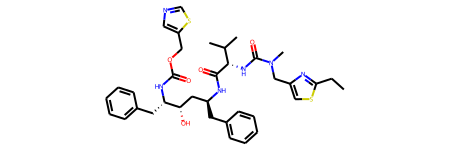

Ergokryptine


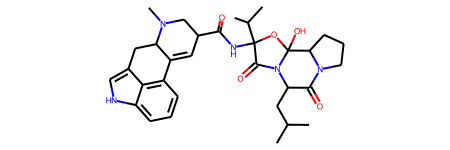

Gallomyricitrin


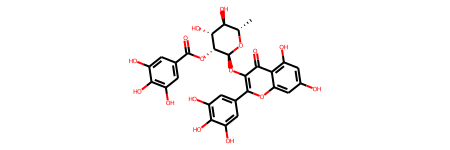

Hms2534f24


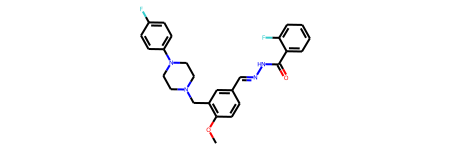

Hydroxyritonavir


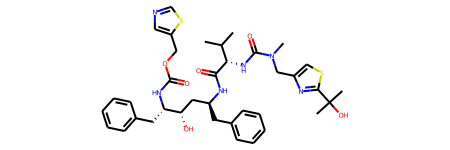

Mls001116157


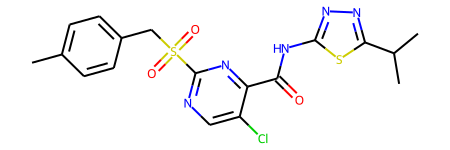

ZINC150339279


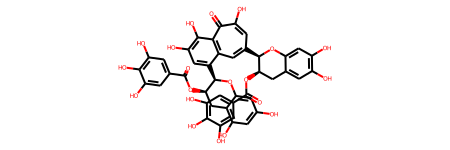

ZINC150346438


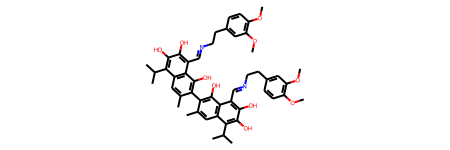

ZINC150357800


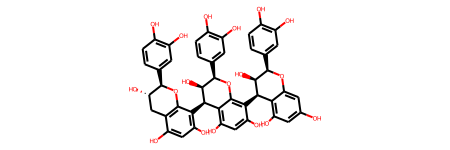

ZINC196939367


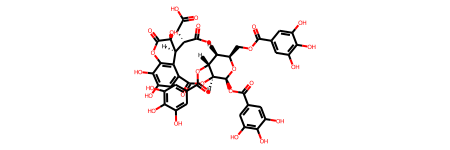

ZINC257355033


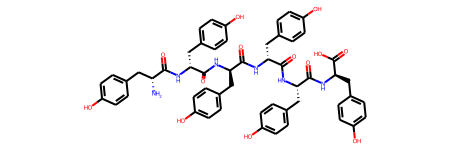

ZINC575229172


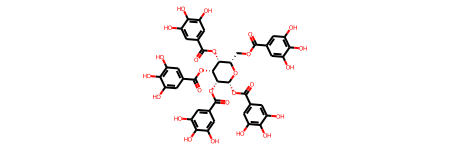

In [30]:
show_molecules_used(Name_list)

### <ins>**3D Ligands representations**</ins>

Helps verify molecules and if the request from the name was correct.

**How:**<br />
A blank model is created using _py3Dmol_ to represent the compounds. The SMILEs of the ligands are requested using _PubChemPy_. They are then introduced to the function _Chem.MolFromSmiles_ from _RDKit_. The hydrogens of the molecules are added using the function _Chem.AddHs_. Each compound is then added to the model _py3Dmol_ using their RDKit objet.

In [31]:
p = show_molecules_used_3D(Name_list)
p.render()

2-Desisopropyl-2-ethyl-Ritonavir
Ergokryptine
Gallomyricitrin
Hms2534f24
Hydroxyritonavir
Mls001116157
ZINC150339279
ZINC150346438
ZINC150357800
ZINC196939367
ZINC257355033
ZINC575229172


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---
# Protein network analysis (Optional)

### <ins>**Betweeness centrality concept**</ins>

The __Betweeness centrality__ meathe ability of a node to lies on paths between other nodes. Hence, proteins or molecules with high betweenness may have an important influence within a network, specially on the control over the informations/interactions passing between others. <br /><br />
**! Most importantly, they are also the ones whose removal from the network will most disrupt communications between other proteins because they lie on the largest number of paths taken by interactions !**
<br /><br />
The betweenness centrality may be computed using weighted or unweighted graphs. In our case, we use the interaction Score from the [String Database](https://string-db.org/ "String Database") as weight for the protein-protein interactions and a normalised activity for the chemical-protein interactions.<br /><br /> 
**Hence, two hypothesis need to be taken in account to evaluate de betweeness centrality:**
1. Every pairs of proteins exchange by contact or undirectly informations with equal probabilities but different importance (weights).<br />
2. The information between two proteins flows along the shortest path separating them.
 

### <ins>**Betweeness centrality theory**</ins><br /> 

**Mathematically:**
* $n_{s,t}^{i}$ is the number of shortest path going from a protein $s$ to a protein $t$ and passing throught the protein $i$ 
* $n_{s,t}$ is the total number of shortest paths from a protein $s$ to a protein $t$, passing or not passing by the protein $i$.

Hence, the betweeness $b_i$ for a protein $i$ can be computed using:

$\displaystyle{b_i = \sum_{s, t} w_{s,t}^{i} = \sum_{s, t} \frac{n_{s,t}^{i}}{n_{s,t}}}$<br />

Where each pair of protein $s, t$ contributes to the sum for a protein $i$ with a weight of interaction $w_{s,t}^{i}$. The value of the betweeness $b_i$ can goes from 0 to 1.

### <ins>**Betweeness centrality implementation**</ins><br /> 

**Input:**<br /> 
_A weighted dictionnary containing the network_<br /> <br /> 
> 1. A dictionnary is used as input to represent the protein-protein-chemical network. To do so, a function have been introduce to convert the tables into a weigthed graph.<br /> 
> 2. The number of neighbors of each protein is computed and stored<br /> 
> 3. A first graph is created by attibuting a zero to each protein. This value will be the location of accumulation of betweeness centrality for each protein.<br /> 
> 4. The shortest path is then compute for each pair of protein located at the limits of the graph. For this, the **Dijkstra's algorithm** is used to find the total of the weights crossed along the shortest path. It's a simpler version of the **A*'s algorithm** which minimize the accumulation of weights from a protein A to a protein B, for the context.<br /> 
> 5. Specific aspects of graphs need to be taken in account, the edges for exemple. For this case, only the paths **$s$** to  **$i$** exist.<br /> 
> 6. Due to the variation of length between the shortest path. The number of visit can variate so much the weight may become faulty. The betweeness of each protein needs then to be normalized after the accumalation. <br /> 

<br /> **Output:**<br /> 
_A table assigning to each protein its betweeness centrality and its number of neighbors_<br /> <br />

In [32]:
if user_paramaters["Network_choice"] != 'Yes: Give path':
    display(cyto)

---
# Target preparation (Optional)

### <ins>**Selection of the proteins**</ins>
Restrict the proteins of interest to a certain cluster, from which structures are selected.

**How:**<br />
Once the betweeness centralities have been computed for each protein of the network. The 10 proteins with the highest betweeness are kept. Considering that the proteins are named using their GeneID in the network, this needs to be changed if we want to recover their PDB structures. To do so, the _mygene_ module is used to translate GeneID to UniprotID. The Uniprot ID are then used to query every PDB ID assigned to each protein by using the [Uniprot Database](https://www.uniprot.org/uniprot/  "Uniprot Database"). <br />

When taking in account that the number of structure per proteins car goes around 20 structures, it becames foolish to dock each one. They are then filtered based firstly on they descriptions and caracteristics. Important informations from each structures is extracted rapidly using _pypdb_, this module help to detect title, resolution, taxonomy and many other crucial data. The GeneID are assigned to their PDB ID and their informations for the next step.

### <ins>**Filtering of the PDB files assigned to each protein**</ins>

To keep only one structure per geneID, PDB data are filtered based on their:

__* title :__<br />
Their title is analyzed to detect any informations about _engineered_, _switched_, _deleted_, _added_ or _mutated_ residues. If it's the case, the structure will go down in the ranking. Because the protein was extracted from a network, the structure need to be the closest from its biological one.
<br />
__* resolution :__<br />
The resolution is an important factor because it can play on the accuracy of the docking results. A good accuracy means results closer from the experimental. A structure with a low resolution will go up in the ranking.
<br />
__* nr_entities :__<br />
The number of entities define the number of object, sub-units, lipids, etc... Hence, it's better to have a number of entites as closed a the number in the biological structure. To do so, this would need a better analysis not held in the present workflow. Hence, structure with high number of entites go down in the ranking, because their is a high probablity for the entities to be parasites (lipids, complexed protein, etc).
<br />
__* nr_residues :__<br />
The number of residues is important to evaluate the size of each chain and if a part of the protein is not present in the structure. So, structure with high number of residues go up in the ranking.
<br />
__* Taxonomy :__<br />
Because the sequence is important when reaction with molecules occurs, the taxonomy is an important player in the selection. For the moment, the workflow take as default the "Human" but a parameter would needed to be set. This would enable to choose between Murin, Human, Rabbit, and others. Thus, extending and predicting experimental assays. For the moment, structure from other organism are taken out is Human structure are present.
<br />
__* weight :__<br />
The weight is a player like the number of residues, it can happened that residues are not complete in structure. Thus, the structure with the complete residues will go up in the ranking against one with one or two beheaded.
<br />
__* chain :__<br />
The number of chain is also a determining factor. It can help choose a structure closer to the biologically active one. The structure wil then have a better rank if the number of sub-units is higher, but a problemresid because proteins can sometimes aggregate, thus resulting an higher number of chain. This part of the workflow would thus need to be adapted in the futur.
<br />
__* mutation :__<br />
Simply, it is better to have no mutation. Proteins with mutation are disclosed if one without are present, for this, the other parameters are ignored.

**The most important parameters to take in account are the _mutation_, the _taxonomy_ and the _title_.**

Once the unconformal PDBs have been eliminated, the remaining one are ranked upon their informations and then, the first one is taken for each protein.

### <ins>**Cleaning and correction of the targets's files**</ins>

As usual, the data need to be clean before managing a docking protocol. To do so,every _heteroatoms_ are removed. The _water_ molecules are also eliminated. Then, considering that structures can contain residues with _shared occupations_, it needs to be treated. If one of the two conformations has a higher ratio, the other one is deleted. If the two conformation have the same ratio, the density surrounding the residues is computed to choose the right one. A residue with a higher density will maybe be involved in tighter interactions and represents a stable conformation, thus, it should be choosed instead of the other one.

---
# Protein visualisation

### <ins>**3D Ligands representations**</ins>

Helps verify if the proteins structures present any defects, unresolved residues and subunits.

* If **"Yes: Give path"** has been selected, the structures represent the given proteins data <br />

* If **"No : Compute network"** has been selected, the structures were recovered from the PDB, selected on criteria and cleaned. <br />
_They might present defects du to the automaticle sorting and cleaning_  <br />

**How:**<br />
A blank model is created using _py3Dmol_ to represent the proteins. Their files are read using the _open().read()_ functions and stored in variables. Each protein is then added one by one to the model _py3Dmol_ using their saved PDB data.

In [33]:
p1 = show_protein(path_to_protein_PDB)
p1.render()

1DGF.pdb
3RPN.pdb
5F9S.pdb
5MWA.pdb
5T30.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---
# Docking protocol



### <ins>**Input preparation**</ins>

Using the newly prepared proteins's structures or the given one. PDBs are converted to the _.pqbqt_ format using the _prepare_receptor4.py_ running with Python2. The proteins are prepared at pH 7.4. The given ligand which were converted to _SMILEs_ are know converted to _.PDB_ format using the_obabel_ module. They are then converted to _.PDBQT_ using _prepare_ligand4.py_.

### <ins>**Method of docking**</ins>

To automatize the sessions of docking. The computation is held by Vina. A futur version will use a version of ADT to choose the grid spacing. For now, the grid is computed by englobing the all protein in the blind docking protocol. In the pocket-based protocol, the location and volume explored is determine using the output of the SAS computation. The docking is then executed. 

### <ins>**Manipulation of the results**</ins>

The poses of docking in the _.out_ files are converted to _.pdb_ and _.mol_ format for easier manipulations from the user. The energies in the _.log_ are stored and organized in a single file named _log_affinity.csv_. Each complex ligand-protein is then generated using the protein's PDB and the conformatin with the lowest energy of each ligand for each protein.

In [34]:
liste_directory_to_show, response, frame, frame_Graphe_1 = execute_docking(Liste_proteins_User, path_to_each_complex, path_to_protein_PDB, user_paramaters)

---
# Complex association

### <ins>**Observe complexes**</ins>

To give an overview, complexe can be easily checked using the following widgets and _pymol3D_ windows

In [39]:
for path_EACH in liste_directory_to_show:
    path_EACH_complex = path_EACH[0]
    path_EACH_name = path_EACH[1]
    print("  Protein :", path_EACH_name)
    show_complex(path_EACH_complex)

  Protein : 1DGF


interactive(children=(IntSlider(value=0, description='confId', max=11), Output()), _dom_classes=('widget-inter…

  Protein : 3RPN


interactive(children=(IntSlider(value=0, description='confId', max=11), Output()), _dom_classes=('widget-inter…

  Protein : 5F9S


interactive(children=(IntSlider(value=0, description='confId', max=11), Output()), _dom_classes=('widget-inter…

  Protein : 5MWA


interactive(children=(IntSlider(value=0, description='confId', max=11), Output()), _dom_classes=('widget-inter…

  Protein : 5T30


interactive(children=(IntSlider(value=0, description='confId', max=11), Output()), _dom_classes=('widget-inter…

In [40]:
frame_Graphe_1

Protein Pocket                          Molecule  Affinity(kcal/mol)  \
177    1DGF     BD  2-Desisopropyl-2-ethyl-Ritonavir                -7.2   
196    1DGF     BD  2-Desisopropyl-2-ethyl-Ritonavir                -7.0   
246    1DGF     BD  2-Desisopropyl-2-ethyl-Ritonavir                -6.6   
297    1DGF     BD  2-Desisopropyl-2-ethyl-Ritonavir                -6.2   
298    1DGF     BD  2-Desisopropyl-2-ethyl-Ritonavir                -6.2   
..      ...    ...                               ...                 ...   
406    5T30     BD                     ZINC575229172                -4.9   
425    5T30     BD                     ZINC575229172                -4.4   
427    5T30     BD                     ZINC575229172                -4.3   
428    5T30     BD                     ZINC575229172                -4.3   
431    5T30     BD                     ZINC575229172                -4.2   

     RMSDl.b.  RMSDu.b  
177     0.000    0.000  
196     2.577    5.289  
246     3.285    5.636  
297     2.919    5.074  
298     2.981    6.170  
..        ...      ...  
406     5.135   11.748  
425     4.633   11.559  
427     6.108   13.157  
428     5.263   12.107  
431     5.384   11.637  

[452 rows x 6 columns]

### <ins>**Repartition of the affinities to each proteins**</ins><br />
The barplot presented here helpsunderstand if one structure has preference upon the set of proteins. It's a method to have an idea if two or more population appear revealing that various ways of interaction exit. <br /><br />
The probability of finding cutt-off proteins will goes higher in multiple populations can be found but it is important to remembere that this plot only give information about the repartition of the affinity. 

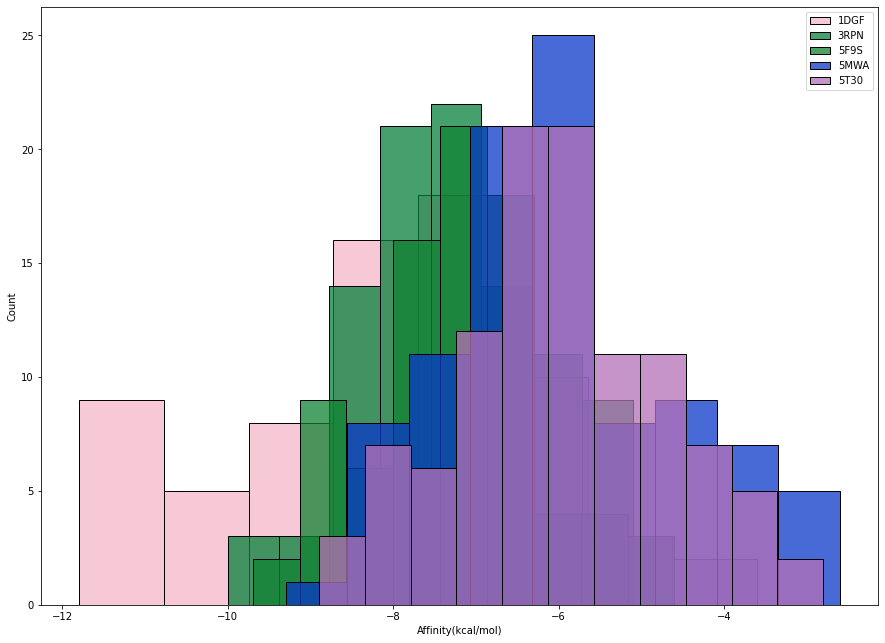

In [48]:
show_affinity_bar(Liste_proteins_User, frame_Graphe_1)

---
# Displaying affinity values

In [49]:
Data_plot = compute_df_mol(frame_Graphe_1)
Data_plot_2 = compute_df_prot(frame_Graphe_1)

### <ins>**Affinity Boxplot per proteins**</ins><br />

The representation of the affinity per per ligand on each protein is used the find is the variability of affinity is variable between ligands. Moreover, an high variability between ligand in one protein and not others can translate an important displacement and pocket preference. This may introduce difficulties to the computation because the pocket-based protocol should be used in this case, with great parcimony.

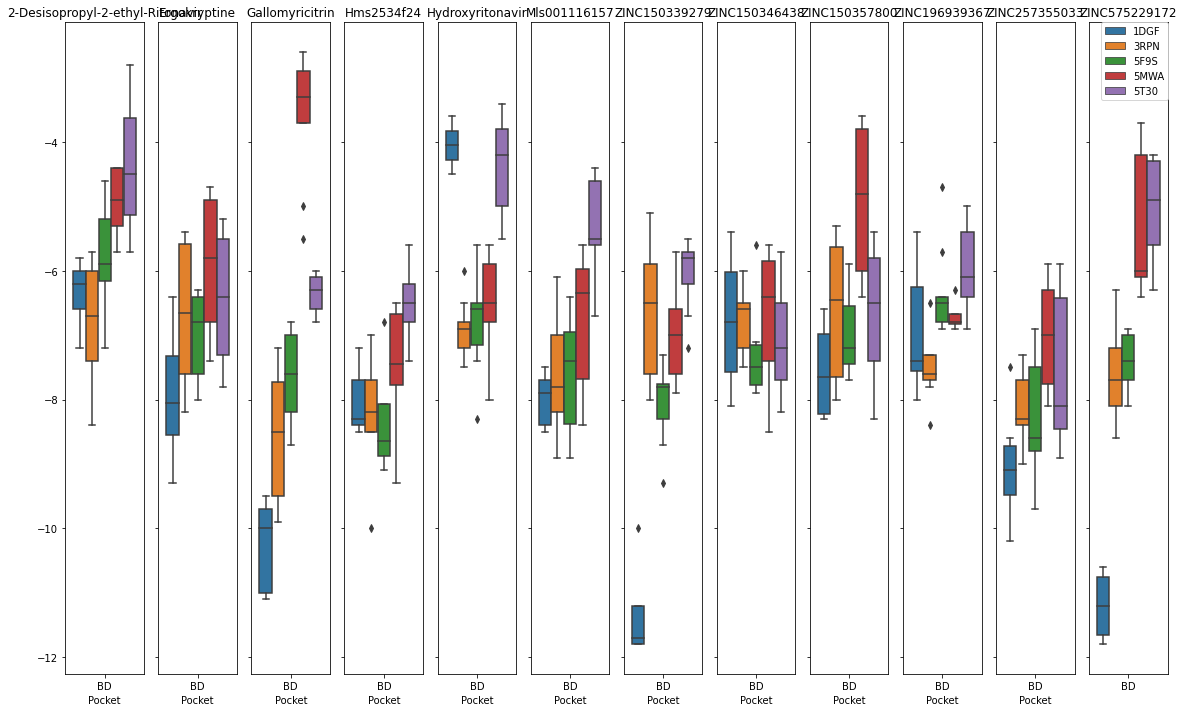

In [50]:
display_protein_by_mol_aff(user_paramaters["Name_list"], frame_Graphe_1)

### <ins>**Affinity Boxplot per proteins**</ins><br />

This version has been produced using _plotly_ has the one before has been created using _matplotlib_. Plotly is very helpful as the median, fence and lower and upper limits can be found easily. The size of the facet can also be controled using the _facet_col_wrap which is very helpfull. 

In [51]:
fig = px.box(frame_Graphe_1, x = "Pocket", y="Affinity(kcal/mol)", facet_col="Molecule", color="Protein", facet_col_wrap=4,
            template="simple_white")
fig.show()

### <ins>**Volcano plot per proteins**</ins><br />

To be able to discern if one ligand is significantl better than another one, a volcano plot can be used. 

<ins>**Volcano plot theory :**</ins><br />

Here, each point of the volcano plot represente a ligand docked to a protein. The Y-axis of the point is computed using a Student test confronting the affinities of the ligand against the affinities of every ligands against the choose protein. The X-axis is computed using a Fold-Change, FC. This variable helps distingish ligands with good affinities from one with bad affinities. The equations are held below. <br />

−log(𝑌) = 𝑓(𝑙𝑜𝑔2(𝑋))

𝑌 = 𝒑𝒗𝒂𝒍𝒖𝒆 𝑑𝑢 𝑐𝑜𝑚𝑝𝑙è𝑥𝑒 𝑙𝑖𝑔𝑎𝑛𝑑00𝑥

𝑋 = 𝑹𝒂𝒕𝒊𝒐 𝒅′𝒂𝒇𝒇𝒊𝒏𝒊𝒕é 𝑑𝑢 𝑑𝑢 𝑐𝑜𝑚𝑝𝑙è𝑥𝑒 𝑙𝑖𝑔𝑎𝑛𝑑𝑥)

𝒑𝒗𝒂𝒍𝒖𝒆 = 𝑡.𝑡𝑒𝑠𝑡(𝐴𝑓𝑓𝑖𝑛𝑖𝑡é 𝑑𝑒𝑠 𝑐𝑜𝑚𝑝𝑙è𝑥𝑒𝑠 𝑙𝑖𝑔𝑎𝑛𝑑𝑥 𝑽𝑺 𝐴𝑓𝑓𝑖𝑛𝑖𝑡é 𝑑𝑒𝑠 𝑐𝑜𝑚𝑝𝑙è𝑥𝑒𝑠 𝑙𝑖𝑔𝑎𝑛𝑑𝑥)

𝑹𝒂𝒕𝒊𝒐 𝒅′𝒂𝒇𝒇𝒊𝒏𝒊𝒕é = 𝑀𝑜𝑦𝑒𝑛𝑛𝑒(𝐴𝑓𝑓𝑖𝑛𝑖𝑡é 𝑑𝑒𝑠 𝑐𝑜𝑚𝑝𝑙è𝑥𝑒𝑠 𝑙𝑖𝑔𝑎𝑛𝑑𝑥) / 𝑀𝑜𝑦𝑒𝑛𝑛𝑒(𝐴𝑓𝑓𝑖𝑛𝑖𝑡é 𝑑𝑒𝑠 𝑐𝑜𝑚𝑝𝑙è𝑥𝑒𝑠 𝑙𝑖𝑔𝑎𝑛𝑑𝑥)<br />

So, points located at the top right of the graph represent ligand with good/low affinities being significantly different from the average.<br />

The graph bellow describes the affinity of each ligand considering their target. It helps found out with complexe has the best affinity and thus, with complex would be the most plossible to forms if the set of compounds was to be gived to the network.

In [52]:
fig = px.scatter(Data_plot_2, x="log2_aff", y="log_pvalue", color="Protein",
            template="simple_white", hover_data=["Molecule"])
fig.show()

### <ins>**Faceted volcano plot per proteins**</ins><br />

In this version, the plot has been cut in function of the compound. It helps choose which protein would be the most interessting for each ligand.

In [53]:
fig = px.scatter(Data_plot, x="log2_aff", y="log_pvalue", color="Protein", facet_col="Molecule", facet_col_wrap=4,
            template="simple_white")
fig.show()

### <ins>**Boxplot per molecules**</ins><br />

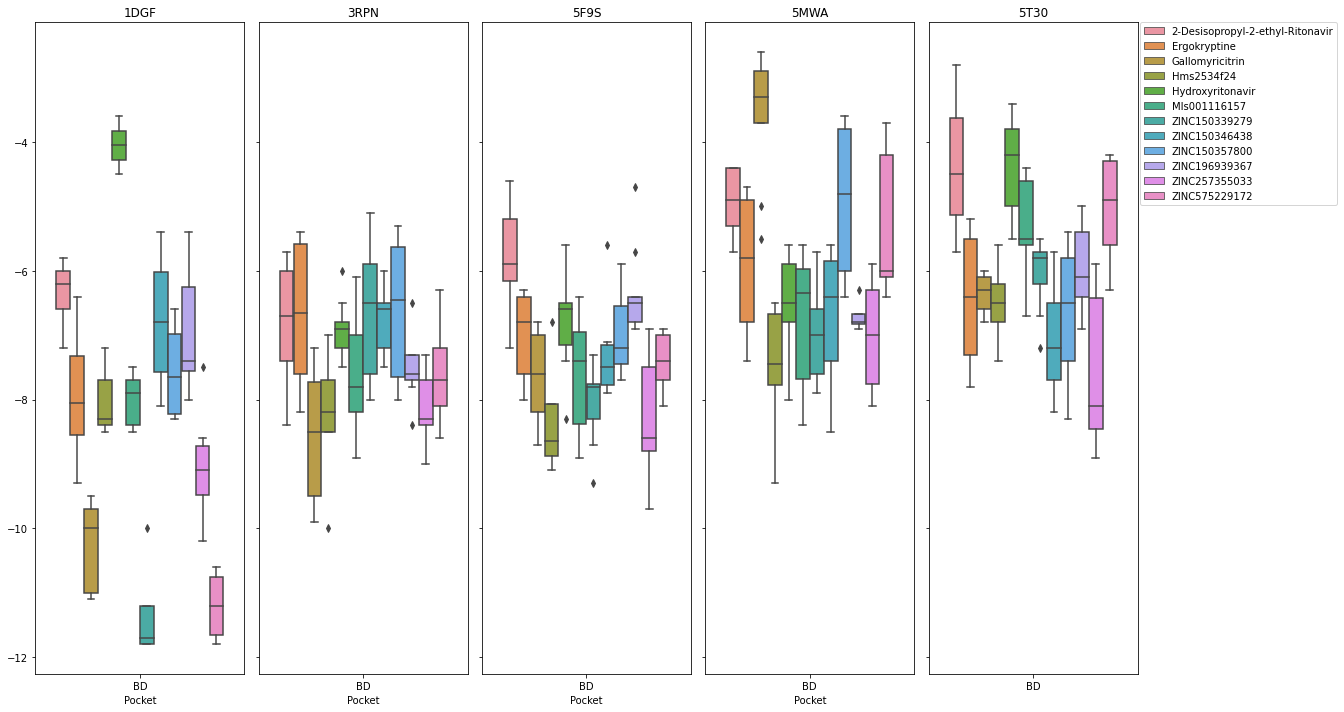

In [54]:
display_mol_aff_by_protein(response, frame_Graphe_1)

### <ins>**Boxplot per molecules**</ins><br />

In [55]:
fig = px.box(frame_Graphe_1, x = "Pocket", y="Affinity(kcal/mol)", facet_col="Protein", color="Molecule", facet_col_wrap=5,
            template="simple_white")
fig.show()

### <ins>**Volcano plot per molecules**</ins><br />

In [56]:
fig = px.scatter(Data_plot_2, x="log2_aff", y="log_pvalue", color="Molecule",
            template="simple_white", hover_data=["Protein"])
fig.show()

### <ins>**Faceted volcano plot per molecules**</ins><br />

In [57]:
fig = px.scatter(Data_plot_2, x="log2_aff", y="log_pvalue", facet_col="Protein", color="Molecule", facet_col_wrap=3,
            template="simple_white")
fig.show()

---
# Similarity computation

### <ins>**Pharmacophore generation**</ins><br />

To compare the poses of the different compounds in the pocket, it has been choosen to transform them to pharmacophore. Hence, the compounds are transformed to pharmacophore depending of their pocket. The pharmacophores created using _RdKit_ are then placed into grid and superimposed for each pocket. 

In [58]:
directory_per_pocket, directory_per_pocket_aff = read_mol_to_rdkit(path_to_each_pose_all)

### <ins>**Pocket to pocket poses alignment**</ins><br />

The points of each grid are then compared by pocket-to-pocket examination. If a point froma grid presents the same pharmacophore type as one on the other grid,the similarity of the pocket-to-pocket analysis is then implemented. The score is converted into a ratio by dividing it by the number of points in the grid.<br />
Due to error occuring during the docking session or the Pharmacophore generation, some poses may not be kept to this stage. Therefor, the number of compounds kept per protein is represented as barplots.

In [59]:
dict_len,df_number_docked = show_protein_and_length(directory_per_pocket)
df_number_docked

Protein pocket  Number of docked compounds
0        1DGF_BD                          71
1        3RPN_BD                          97
2        5F9S_BD                          83
3        5MWA_BD                          95
4        5T30_BD                         106

In [60]:
fig = px.bar(df_number_docked, x='Protein pocket', y='Number of docked compounds', color = "Protein pocket",
            template="simple_white")
fig.show()

### <ins>**Display pocket poses alignment**</ins><br />

To evaluate the quality of the alignement and which functionnal groups are surimpose in each one. A _pymol3D_ window and multiple widgets are used to display the molecules.

**Aligned compounds :**<br />
Input here the name of the protein from which you want to see the aligned compounds<br />

**Max. Compounds :**<br />
Define the number of compounds used in the alignment box. Choosing a small number is better to have a fast idea of the alignement<br />

**% Compounds :**<br />
A variable to choose the ratio of generated pharmacophore to keep. Due to the number of poses and considering that each compound can produce around 10-30 pharmacophre. The time of computation of the pharmacophore alignement can increase exponentially if an important ratio is choosed. <br />

**Features category :**<br />
The pharmacophore generating function from _RDKit_ can computes two categories of pharmacophore, differing on their accury. Pharmacophores from the **Family** are H-bond donors, H_bond acceptors, hydropobic functions, etc....<br />
Pharmacophores from the **Type** familly will be more precise by defining aromatics, heteroatomic rings, imidazole, precise functional groups, etc...<br />
The accuracy of the alignement will depend mostly on this variable. Because accuracy is key, it is advise to choose **Type**/<br />

In [61]:
display(choosed_pocket_t)
choosed_pocket = str(choosed_pocket_t.value.strip())
Aligned_str = alignement_numb(choosed_pocket)

Text(value='5F9S_BD', description='Aligned compounds', placeholder='Protein_Pocket', style=DescriptionStyle(de…

In [62]:
display(Aligned_str, Pourcent_mol, type_of_level_choice)

IntSlider(value=20, description='Max. Compounds', max=83, min=2, style=SliderStyle(description_width='initial'…

IntSlider(value=5, description='% Compounds', min=1, style=SliderStyle(description_width='initial', handle_col…

RadioButtons(description='Features category', options=('Family', 'Type'), style=DescriptionStyle(description_w…

In [63]:
p_crippen = py3Dmol.view(width=600, height=400)
show_structure(directory_per_pocket, directory_per_pocket_aff, choosed_pocket, variables_def, p_crippen, Aligned_str).render()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [64]:
type_of_level = type_of_level_choice.value
num_pharma_to_keep = int(Pourcent_mol.value)
similarity_pharmacophore, dictionnary_pharma_voxel = execute_pharmacophote_alignment(directory_per_pocket, directory_per_pocket_aff , num_pharma_to_keep, type_of_level, path_to_each_pose_all, show_structure_ACTION, write_align, include_molecule, compute_voxel, create_clean_pharm, variables_def, find_center_of_mass_O, center_pharmacophores, voxel_all, from_zero_grid_to_one, translate_protein_PHARMA)

---
# Pocket-to-Pocket ratios of similarity

### <ins>**Similarity barplot of each protein-to-protein pair**</ins><br />

The pairs similarities are represented as barplots. This helps to understand with a first approach which protein pairs may presents off-target events. Pairs with high similarity have highest probability to present off-target events.

In [65]:
Similarity_per_pairs = pd.DataFrame(similarity_pharmacophore,columns = ["Pocket-pairs", "Similarity"]).sort_values(by='Similarity')
Similarity_per_pairs

Pocket-pairs  Similarity
3  3RPN_BD_1DGF_BD    0.437754
8  5MWA_BD_1DGF_BD    0.578084
6  5F9S_BD_1DGF_BD    0.607944
2  3RPN_BD_5T30_BD    0.660836
9  5T30_BD_1DGF_BD    0.661653
0  3RPN_BD_5F9S_BD    0.662644
1  3RPN_BD_5MWA_BD    0.734098
7  5MWA_BD_5T30_BD    0.843642
4  5F9S_BD_5MWA_BD    0.875691
5  5F9S_BD_5T30_BD    0.880996

In [66]:
fig = px.bar(Similarity_per_pairs, x='Pocket-pairs', y='Similarity', color = "Pocket-pairs",
            template="simple_white")
fig.show()

### <ins>**Affinity against similarity**</ins><br />

To represent easily and correctly the chance of off-target. The values affinity per pocket docked are grouped together and a Student test is used to evaluate their significative difference against the other pairs. Thus, pairs with high similarities and -log(p-value) are possible off-target actors. To color this possibility, the addition off the -log(p-value) with the log in base 2 of the similarity has been made.

In [67]:
Ready_pd = prepare_similarity_plot(similarity_pharmacophore, frame_Graphe_1)
Ready_pd

log2_Similarity_fold  log_pvalue       Duo_Pocket  \
0             -0.067396    0.337509  3RPN_BD-5F9S_BD   
7              0.281000    0.012066  5MWA_BD-5T30_BD   
3             -0.665509    8.973173  3RPN_BD-1DGF_BD   
6             -0.191692    9.025511  5F9S_BD-1DGF_BD   
4              0.334792   21.310663  5F9S_BD-5MWA_BD   
1              0.080343   25.229910  3RPN_BD-5MWA_BD   
5              0.343506   26.067226  5F9S_BD-5T30_BD   
2             -0.071339   30.672044  3RPN_BD-5T30_BD   
8             -0.264352   32.383519  5MWA_BD-1DGF_BD   
9             -0.069556   37.973890  5T30_BD-1DGF_BD   

   log2_Similarity_fold + log_pvalue  
0                              0.270  
7                              0.293  
3                              8.308  
6                              8.834  
4                             21.645  
1                             25.310  
5                             26.411  
2                             30.601  
8                             32.119  
9                             37.904

In [68]:
fig = px.scatter(Ready_pd, x="log2_Similarity_fold", y="log_pvalue", text="Duo_Pocket", color="log2_Similarity_fold + log_pvalue",
            template="simple_white")
fig.update_traces(textposition='top center')
fig.show()

The final result of the workflow is held here. The possible off target are located in the top right location of the volcano plot, they are colored in yellow.